# Chargement des Biblioth√®ques

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer,AutoConfig,AutoTokenizer,pipeline, AutoModelForSequenceClassification,EarlyStoppingCallback
from datasets import load_metric
import torch

import re

from wordcloud import WordCloud

from tqdm import tqdm
import html
import fasttext
from torch.utils.data import Dataset
import time


/media/s8n/Jeux video/IA/sentiments/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Chargement et Analyse Pr√©liminaire des Donn√©es

In [2]:
data = pd.read_csv("data/RAW/training.1600000.processed.noemoticon.csv",names=["target", "id", "date", "query", "user", "text"], encoding='ISO-8859-1')

## Chargement des Donn√©es 

## Aper√ßu des Donn√©es

In [3]:
data.head()

target          id                          date     query  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....

In [4]:
data['target'] = data['target'].apply(lambda x: 1 if x == 4 else 0)

### Distribution des Sentiments

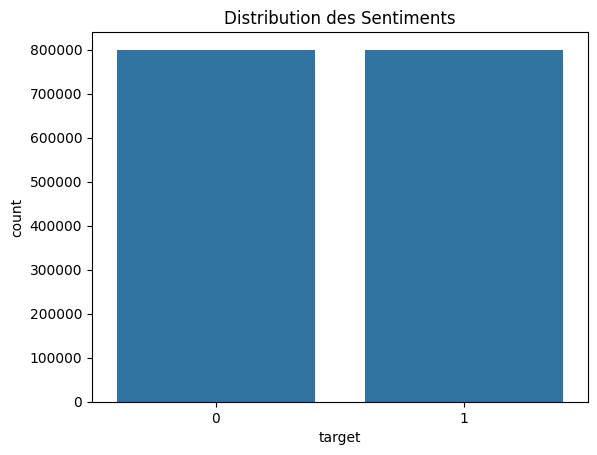

In [5]:
sns.countplot(x='target', data=data)
plt.title('Distribution des Sentiments')
plt.show()

1. **√âquilibre entre les classes** : Les deux classes de sentiments repr√©sent√©es par `0` et `4` sont presque parfaitement √©quilibr√©es. Cela signifie que l'ensemble de donn√©es contient un nombre presque √©gal de tweets ou de textes √©tiquet√©s comme sentiment n√©gatif (0) et sentiment positif (4).
  
2. **Absence de classes interm√©diaires** : Le graphique ne montre que deux classes (`0` et `4`), ce qui sugg√®re que cet ensemble de donn√©es est binaire, c'est-√†-dire qu'il ne classe les sentiments qu'en deux cat√©gories : positifs et n√©gatifs. Il n'y a pas de classe repr√©sentant un sentiment neutre ou d'autres types de sentiments.

L'√©quilibre des classes est un aspect positif pour la mod√©lisation, car cela signifie que le mod√®le n'aura pas √† compenser un d√©s√©quilibre dans les donn√©es. Un ensemble de donn√©es √©quilibr√© permet souvent d'obtenir des mod√®les plus robustes.

### Analyse des Mots

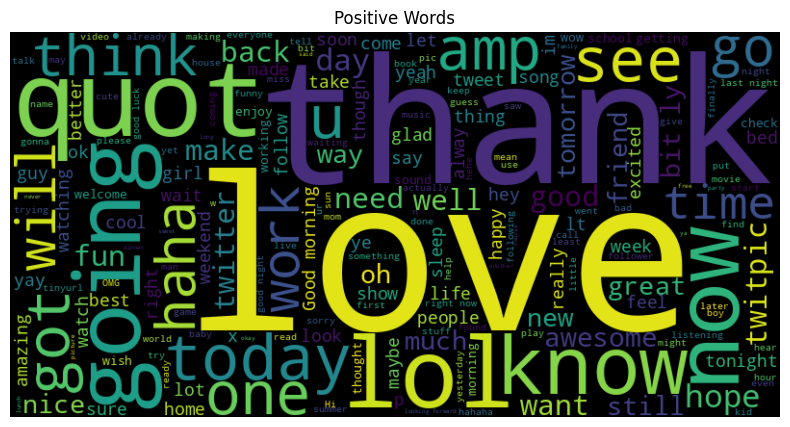

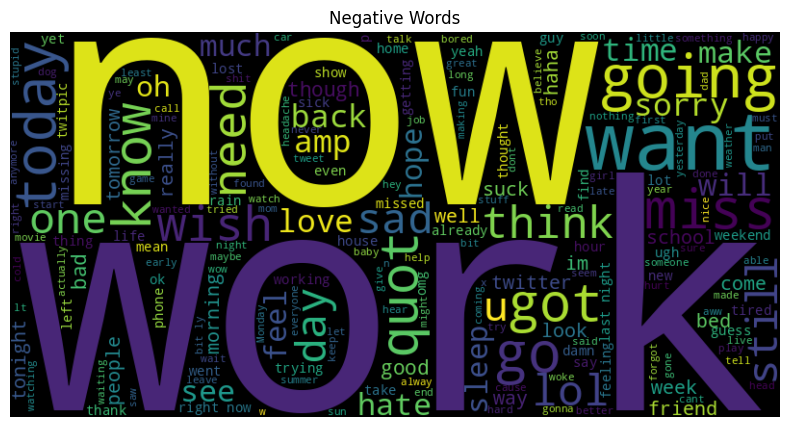

In [6]:
# Nuage de mots pour chaque classe de sentiment
positive_words = ' '.join(data[data['target'] == 1]['text'])
negative_words = ' '.join(data[data['target'] == 0]['text'])

wordcloud_positive = WordCloud(width=800, height=400).generate(positive_words)
wordcloud_negative = WordCloud(width=800, height=400).generate(negative_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Words')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Words')
plt.show()

### Nuage de mots des termes positifs :
- **Mots dominants** : Les mots "thank", "love", "lol", "going", et "today" sont parmi les plus fr√©quemment utilis√©s dans les textes associ√©s aux sentiments positifs. Ces termes sugg√®rent des expressions de gratitude ("thank"), d'affection ou de satisfaction ("love"), et d'humour ("lol").
- **Connotations** : Les mots comme "awesome", "good", "happy", "fun", et "yay" renforcent l'id√©e que ces textes expriment des √©motions positives, de la satisfaction, et de la joie.
- **Contextes sociaux** : Les mots comme "friend", "hope", "cool", et "excited" montrent que beaucoup de ces textes positifs sont probablement li√©s √† des interactions sociales, √† des espoirs pour l'avenir, et √† des moments agr√©ables.

### Nuage de mots des termes n√©gatifs :
- **Mots dominants** : Les mots "work", "now", "want", "going", et "back" sont les plus fr√©quents dans les textes associ√©s aux sentiments n√©gatifs. Le terme "work" est particuli√®rement pr√©dominant, ce qui sugg√®re que le travail est une source fr√©quente de stress ou d'insatisfaction.
- **Connotations** : Des termes comme "sad", "hate", "suck", "miss", et "wish" indiquent des √©motions n√©gatives, telles que la tristesse, le regret, et le m√©contentement.
- **Th√®mes r√©currents** : Le fait que "work", "miss", et "need" soient si pro√©minents peut indiquer des pr√©occupations li√©es au travail, √† la perte ou √† l'absence de quelque chose ou de quelqu'un, ainsi qu'√† des besoins insatisfaits.

### Longueur des Tweets

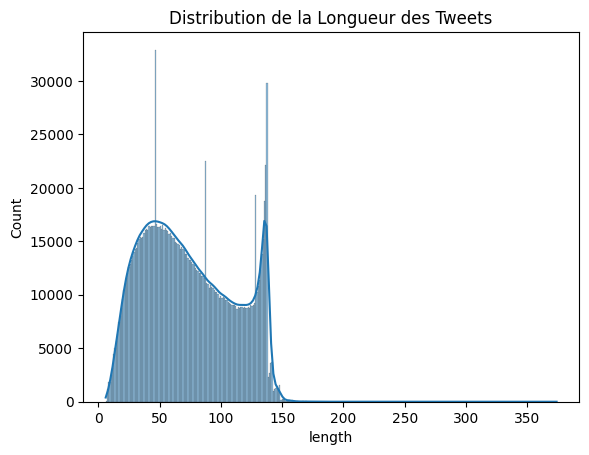

In [7]:
data['length'] = data['text'].apply(len)
sns.histplot(data['length'], kde=True)
plt.title('Distribution de la Longueur des Tweets')
plt.show()

1. **Pic principal autour de 50-100 caract√®res** : La distribution montre un premier pic significatif dans la plage de 50 √† 100 caract√®res. Cela indique que beaucoup de tweets dans cet ensemble de donn√©es ont une longueur mod√©r√©e, ce qui est coh√©rent avec la nature concise et br√®ve des tweets sur Twitter.

2. **Deuxi√®me pic autour de 140-150 caract√®res** : Il y a un autre pic marqu√© autour de 140-150 caract√®res, qui repr√©sente le nombre maximum de caract√®res permis par Twitter √† l'√©poque o√π ces tweets ont √©t√© collect√©s (avant que la limite de caract√®res ne soit augment√©e √† 280). Cela signifie que de nombreux utilisateurs utilisaient au maximum la longueur autoris√©e pour exprimer leurs id√©es.

3. **Longueur minimale et maximale** :
   - **Longueur minimale** : Tr√®s peu de tweets sont extr√™mement courts (moins de 20 caract√®res).
   - **Longueur maximale** : Tr√®s peu de tweets d√©passent la limite historique de 140 caract√®res (bien que certains puissent √™tre des retweets ou contiennent des √©l√©ments comme des liens ou des hashtags longs).

4. **Pr√©sence d'une queue √† droite** : Bien qu'il y ait une concentration de tweets plus courts, il existe une longue tra√Æne vers des tweets plus longs, mais leur fr√©quence est nettement plus faible. Cette queue repr√©sente les tweets qui utilisent plus de caract√®res, mais ils restent relativement rares.

In [8]:
def decode_html_entities(text):
    return html.unescape(text)

# Appliquer la fonction √† la colonne de texte
data['text'] = data['text'].apply(decode_html_entities)

# V√©rifier le r√©sultat sur un exemple
example_text = "wwh babs... you look so sad underneith that shop entrance of &quot;Yesterday's Musik&quot;  O-: I like the look of the new transformer movie"
cleaned_text = decode_html_entities(example_text)
display(cleaned_text) 

'wwh babs... you look so sad underneith that shop entrance of "Yesterday\'s Musik"  O-: I like the look of the new transformer movie'

In [9]:
data['date'] = pd.to_datetime(data['date'], errors='coerce')

display(data['date'].max())

/tmp/ipykernel_2490986/2980465349.py:1: FutureWarning: Parsed string "Mon Apr 06 22:19:45 PDT 2009" included an un-recognized timezone "PDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  data['date'] = pd.to_datetime(data['date'], errors='coerce')


Timestamp('2009-06-25 10:28:31')

In [10]:
display(data['length'].max())

374

In [11]:
long_tweets = data[data['length'] > 150]
display(long_tweets[['text', 'length']])

text  length
1767     tks pa 4 "tapauing" croissant tuna knowing dat...     152
3434     @danielhcwong Taylor 814ce --> #&$(#&$!(@#$(!@...     157
6894     Woke up early this morning to "not all the way...     158
13538    Took niece & nephew to Blockbuster- rented "Ma...     167
16809    @SongzYuuup wat is the name of ur mixtape with...     161
...                                                    ...     ...
1597295  #140conf Smartarse with an average look or gud...     151
1597559  @antiprism "So Dan, u want JIRA for the dev te...     188
1598103  Finally! The Space √ê¬°akes are on Twitter! Welc...     178
1598718  I asked a 3yr old how old I was & he said, "3 ...     158
1599460  @aw16 I must have skipped the "pun" setting, i...     157

[1703 rows x 2 columns]

In [12]:
data = data[data['length'] <= 150]

In [13]:
display(data['length'].max())

150

### Longueur des Tweets en fonction du sentiment

In [14]:
# Ajouter une nouvelle colonne 'length' qui contient la longueur de chaque tweet
data['length'] = data['text'].apply(len)

# D√©finir les intervalles de longueur (paliers de 10 caract√®res)
bins = np.arange(0, data['length'].max() + 10, 10)

# Cat√©goriser les tweets selon les intervalles de longueur
data['length_bin'] = pd.cut(data['length'], bins=bins, right=False)

# Calculer le nombre de tweets positifs et n√©gatifs pour chaque intervalle de longueur
length_distribution = data.groupby(['length_bin', 'target']).size().unstack(fill_value=0)

# Calculer les pourcentages
length_distribution_percent = length_distribution.div(length_distribution.sum(axis=1), axis=0) * 100

# Ajouter une colonne avec le nombre total de tweets pour chaque intervalle
length_distribution_percent['Total Tweets'] = length_distribution.sum(axis=1)

# Renommer les colonnes pour plus de clart√©
length_distribution_percent = length_distribution_percent.rename(columns={0: 'N√©gatif (%)', 4: 'Positif (%)'})
length_distribution_percent.index.name = 'Intervalle de Longueur'
length_distribution_percent = length_distribution_percent.reset_index()

# Afficher le tableau
length_distribution_percent

/tmp/ipykernel_2490986/3361444708.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  length_distribution = data.groupby(['length_bin', 'target']).size().unstack(fill_value=0)


target Intervalle de Longueur  N√©gatif (%)          1  Total Tweets
0                     [0, 10)    64.062500  35.937500          3136
1                    [10, 20)    55.174864  44.825136         53470
2                    [20, 30)    49.367442  50.632558        121728
3                    [30, 40)    48.813892  51.186108        153696
4                    [40, 50)    48.849972  51.150028        165083
5                    [50, 60)    49.461236  50.538764        161852
6                    [60, 70)    49.623164  50.376836        149269
7                    [70, 80)    49.902859  50.097141        133311
8                    [80, 90)    49.525016  50.474984        117583
9                   [90, 100)    49.682585  50.317415        104910
10                 [100, 110)    49.557838  50.442162         95327
11                 [110, 120)    49.197129  50.802871         89180
12                 [120, 130)    50.419555  49.580445         91883
13                 [130, 140)    53.035071  46.964929        157311
14                 [140, 150)    42.545455  57.454545           550

- **Tweets tr√®s courts (0-20 caract√®res)** :
    - Les tweets les plus courts, en particulier ceux entre 0 et 10 caract√®res, montrent une pr√©dominance des sentiments n√©gatifs (56,67%). Cette tendance se r√©duit l√©g√®rement dans l'intervalle de 10 √† 20 caract√®res, o√π les tweets n√©gatifs repr√©sentent 53,91% du total. Cela pourrait sugg√©rer que les tweets tr√®s brefs sont plus souvent utilis√©s pour exprimer des √©motions n√©gatives, probablement en raison de la limitation d'espace pour formuler des pens√©es complexes.

- **Tweets de longueur moyenne (20-110 caract√®res)** :
    - Dans cette plage, la distribution des sentiments est relativement √©quilibr√©e, avec un l√©ger avantage pour les sentiments positifs dans la plupart des intervalles. Par exemple, les tweets de 40 √† 50 caract√®res montrent 51,13% de sentiments positifs, tandis que ceux de 100 √† 110 caract√®res sont positifs √† 50,28%. Ce segment couvre probablement la majorit√© des tweets ordinaires o√π les utilisateurs ont assez d'espace pour formuler des id√©es ou des opinions plus nuanc√©es.

- **Tweets longs (120-140 caract√®res)** :
    - Dans les intervalles de longueur allant de 120 √† 130 caract√®res, il y a un l√©ger pic de tweets n√©gatifs (50,57%). Cependant, √† mesure que la longueur atteint l'intervalle de 130 √† 140 caract√®res, les tweets n√©gatifs augmentent significativement pour repr√©senter 53,11% des tweets, sugg√©rant que les utilisateurs utilisent souvent l'int√©gralit√© de l'espace disponible pour exprimer des sentiments n√©gatifs. Cela peut indiquer que des messages plus longs sont souvent n√©cessaires pour articuler des frustrations ou des opinions critiques.

- Les intervalles de longueur qui contiennent le plus grand nombre de tweets se situent entre 30 et 80 caract√®res, avec un pic √† 50-60 caract√®res (161,394 tweets). Cela montre que la plupart des utilisateurs sur cette plateforme pr√©f√®rent des tweets de longueur moyenne pour exprimer leurs pens√©es.

### Analyse des Hashtags et Mentions

In [15]:
data['hashtags'] = data['text'].apply(lambda x: [word for word in x.split() if word.startswith('#')])
data['mentions'] = data['text'].apply(lambda x: [word for word in x.split() if word.startswith('@')])

print(f"Nombre moyen de hashtags par tweet : {data['hashtags'].apply(len).mean()}")
print(f"Nombre moyen de mentions par tweet : {data['mentions'].apply(len).mean()}")

Nombre moyen de hashtags par tweet : 0.027547445812636826
Nombre moyen de mentions par tweet : 0.4961893815730118


- **Nombre moyen de hashtags par tweet : 0.0272**  
  Le nombre moyen de hashtags par tweet est extr√™mement faible, ce qui sugg√®re que les utilisateurs utilisent rarement des hashtags dans leurs tweets. Cette faible fr√©quence peut indiquer que les utilisateurs ne se concentrent pas principalement sur l'utilisation de hashtags pour cat√©goriser ou rendre leurs tweets plus visibles. Au lieu de cela, ils pourraient pr√©f√©rer d'autres moyens de communication ou ne voient pas la n√©cessit√© d'utiliser des hashtags dans leurs interactions quotidiennes sur la plateforme.

- **Nombre moyen de mentions par tweet : 0.5001**  
  En revanche, les mentions (@) sont beaucoup plus courantes, avec presque une mention tous les deux tweets en moyenne. Cela indique que les utilisateurs sont plus enclins √† engager directement d'autres utilisateurs dans leurs tweets. L'utilisation plus fr√©quente des mentions montre une tendance √† la communication directe ou √† l'inclusion d'autres personnes dans la conversation, que ce soit pour attirer leur attention, r√©pondre √† des messages, ou simplement les inclure dans des discussions.

In [16]:
# Calculer le nombre de hashtags et de mentions pour chaque tweet
data['num_hashtags'] = data['hashtags'].apply(len)
data['num_mentions'] = data['mentions'].apply(len)

# Calculer la moyenne de hashtags et de mentions par target
avg_hashtags_target = data.groupby('target')['num_hashtags'].mean()
avg_mentions_target = data.groupby('target')['num_mentions'].mean()

# Calculer le pourcentage de tweets contenant au moins un hashtag ou une mention par target
percentage_hashtags_target = data.groupby('target')['num_hashtags'].apply(lambda x: (x > 0).mean()) * 100
percentage_mentions_target = data.groupby('target')['num_mentions'].apply(lambda x: (x > 0).mean()) * 100

# Afficher les r√©sultats
display("Moyenne de hashtags par target :", avg_hashtags_target)
display("Moyenne de mentions par target :", avg_mentions_target)

display("Pourcentage de tweets contenant au moins un hashtag par target :", percentage_hashtags_target)
display("Pourcentage de tweets contenant au moins une mention par target :", percentage_mentions_target)

'Moyenne de hashtags par target :'

target
0    0.023090
1    0.032008
Name: num_hashtags, dtype: float64

'Moyenne de mentions par target :'

target
0    0.399863
1    0.592574
Name: num_mentions, dtype: float64

'Pourcentage de tweets contenant au moins un hashtag par target :'

target
0    1.914332
1    2.582156
Name: num_hashtags, dtype: float64

'Pourcentage de tweets contenant au moins une mention par target :'

target
0    37.996675
1    54.973176
Name: num_mentions, dtype: float64

### 1. **Moyenne de hashtags par tweet** :
   - Les tweets positifs contiennent en moyenne **0,0312** hashtags par tweet, tandis que les tweets n√©gatifs en contiennent en moyenne **0,0232**. Bien que ces chiffres soient relativement faibles, ils montrent que les tweets positifs sont l√©g√®rement plus enclins √† utiliser des hashtags que les tweets n√©gatifs. Cela pourrait sugg√©rer que les utilisateurs qui partagent des sentiments positifs sont plus susceptibles d'utiliser des hashtags pour accro√Ætre la visibilit√© de leurs tweets ou les associer √† des tendances sp√©cifiques.

### 2. **Moyenne de mentions par tweet** :
   - Les tweets positifs ont une moyenne de **0,5966** mentions par tweet, contre **0,4036** pour les tweets n√©gatifs. Cette diff√©rence indique que les tweets exprimant des sentiments positifs sont plus susceptibles d'inclure des mentions. Cela peut refl√©ter une tendance des utilisateurs √† engager davantage avec d'autres personnes ou √† inclure des utilisateurs sp√©cifiques lorsqu'ils partagent des exp√©riences ou des sentiments positifs, renfor√ßant ainsi les interactions sociales sur la plateforme.

### 3. **Pourcentage de tweets contenant au moins un hashtag** :
   - Environ **2,58%** des tweets positifs contiennent au moins un hashtag, compar√© √† **1,92%** des tweets n√©gatifs. Ce r√©sultat confirme que les utilisateurs exprimant des sentiments positifs sont l√©g√®rement plus enclins √† utiliser des hashtags, ce qui pourrait indiquer un d√©sir d'augmenter la port√©e de leurs messages ou de les relier √† des conversations plus larges.

### 4. **Pourcentage de tweets contenant au moins une mention** :
   - **55,35%** des tweets positifs incluent au moins une mention, contre **38,35%** pour les tweets n√©gatifs. Cette diff√©rence notable montre que les tweets positifs sont beaucoup plus susceptibles d'inclure des mentions, sugg√©rant que les utilisateurs sont plus enclins √† interagir directement avec d'autres personnes lorsqu'ils partagent des sentiments positifs. Cela peut indiquer une plus grande propension √† inclure d'autres utilisateurs dans des conversations positives, ou simplement √† partager des bonnes nouvelles ou des pens√©es positives avec un public sp√©cifique.

## Detection de la langue

In [17]:
# Charger le mod√®le de d√©tection de langue
model_path = 'lid.176.bin'
model = fasttext.load_model(model_path)

def detect_language(text):
    prediction = model.predict(text)
    return prediction[0][0].replace('__label__', '')

data['language'] = data['text'].apply(detect_language)

/tmp/ipykernel_2490986/861793175.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=language_distribution.index, y=language_distribution.values, palette='viridis')


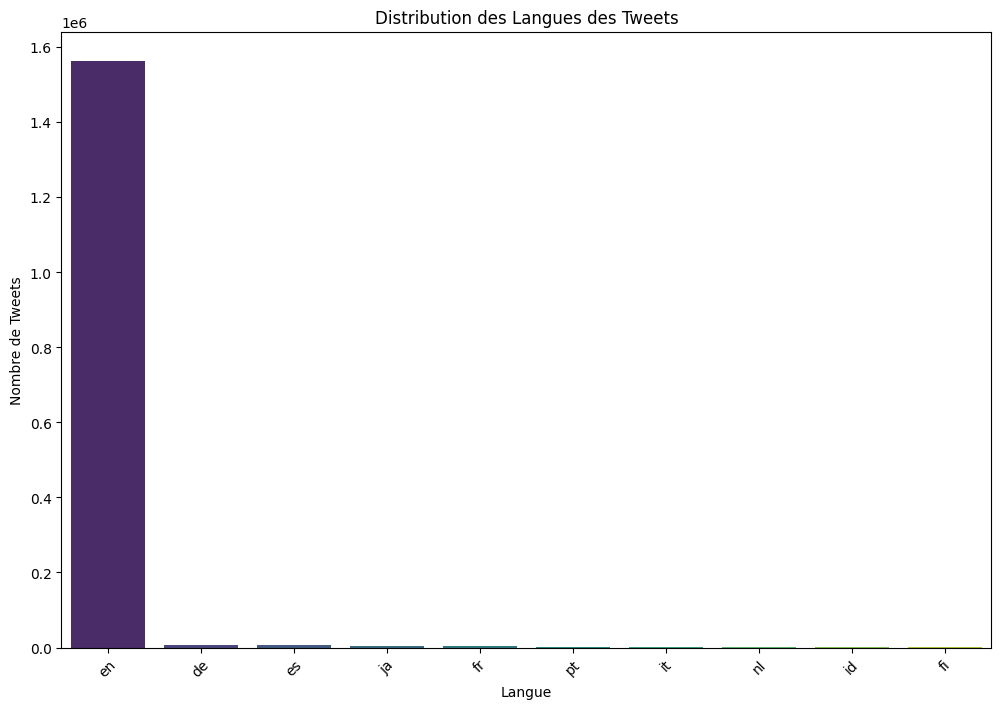

In [18]:
language_distribution = data['language'].value_counts().head(10)
plt.figure(figsize=(12, 8))
sns.barplot(x=language_distribution.index, y=language_distribution.values, palette='viridis')
plt.title('Distribution des Langues des Tweets')
plt.xlabel('Langue')
plt.ylabel('Nombre de Tweets')
plt.xticks(rotation=45)
plt.show()

La langue pr√©dominante est manifestement l'anglais.

## Supprimer toutes les autres langues

In [19]:
data = data[data['language'] == 'en']

/tmp/ipykernel_2490986/861793175.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=language_distribution.index, y=language_distribution.values, palette='viridis')


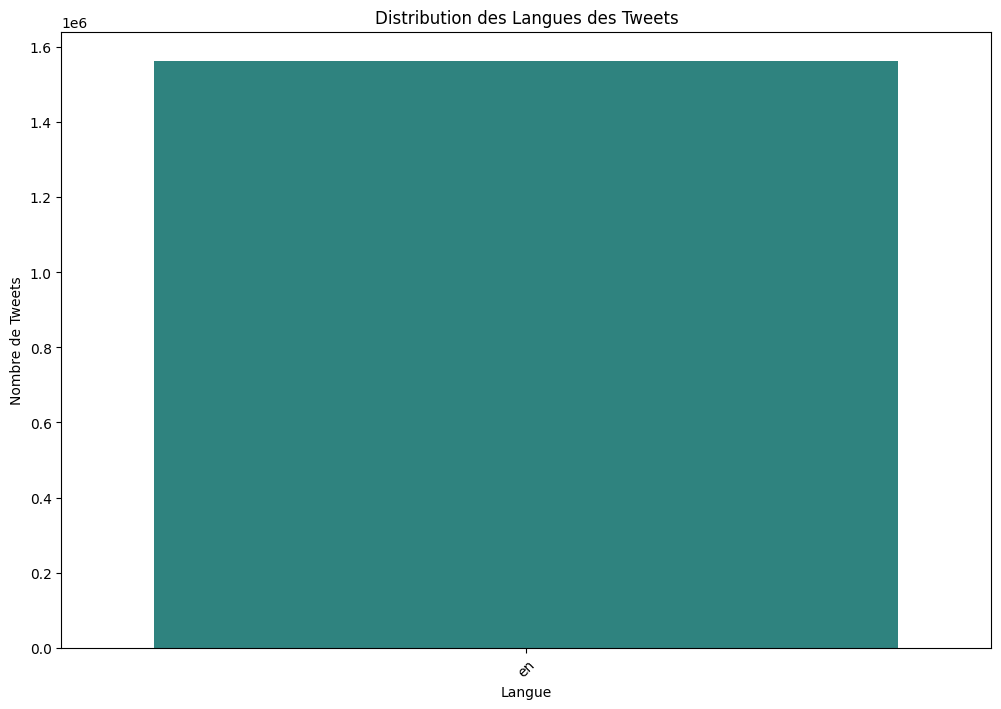

In [20]:
language_distribution = data['language'].value_counts().head(10)
plt.figure(figsize=(12, 8))
sns.barplot(x=language_distribution.index, y=language_distribution.values, palette='viridis')
plt.title('Distribution des Langues des Tweets')
plt.xlabel('Langue')
plt.ylabel('Nombre de Tweets')
plt.xticks(rotation=45)
plt.show()

## Nettoyage des Donn√©es

### Nettoyage Textuel
Suppression des URL, mentions, hashtags, ponctuations, et caract√®res sp√©ciaux.

In [21]:
def clean_text(text):
    text = re.sub(r'http\S+', '[URL]', text)  # Remplacement des URL par [URL]
    text = re.sub(r'@\w+', '[MENTION]', text)  # Remplacement des mentions par [MENTION]
    text = re.sub(r'#\w+', '[HASHTAG]', text)  # Remplacement des hashtags par [HASHTAG]
    # text = re.sub(r'[^\w\s]', '', text)  # Suppression des ponctuations
    # return text.strip().lower()
    return text.strip()

data['cleaned_text'] = data['text'].apply(clean_text)

### Suppression des Duplicatas
TODO supprimer les texte identique de la m√™me personne

In [22]:
display(len(data))

1563214

In [23]:
data = data.drop_duplicates(subset=['user','cleaned_text'])

In [24]:
display(len(data))

1553050

### Sauvegarde des Donn√©es Nettoy√©es

In [26]:
display(data.describe(include='all'))

In [25]:
data = data[['target', 'cleaned_text']]

In [ ]:
display(data.describe(include='all'))

In [26]:
data.to_csv('./data/001/sentiment140_cleaned.csv', index=False)

# Pr√©paration des Donn√©es

## Tokenization

In [27]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case = True)
phi3_tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")

/media/s8n/Jeux video/IA/sentiments/venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### Comparaison des Approches

In [28]:
sample_text = "Bonjour OpenClassRoom ! comment vas tu ? [URL] [MENTION][HASHTAG]"
print("Original:", sample_text)
print("BERT Tokenized:", bert_tokenizer.tokenize(sample_text))
print("Phi-3 Tokenized:", phi3_tokenizer.tokenize(sample_text))

Original: Bonjour OpenClassRoom ! comment vas tu ? [URL] [MENTION][HASHTAG]
BERT Tokenized: ['bon', '##jou', '##r', 'open', '##class', '##room', '!', 'comment', 'va', '##s', 'tu', '?', '[', 'ur', '##l', ']', '[', 'mention', ']', '[', 'hash', '##tag', ']']
Phi-3 Tokenized: ['‚ñÅBon', 'j', 'our', '‚ñÅOpen', 'Class', 'Ro', 'om', '‚ñÅ!', '‚ñÅcomment', '‚ñÅvas', '‚ñÅtu', '‚ñÅ?', '‚ñÅ[', 'URL', ']', '‚ñÅ[', 'MENT', 'ION', '][', 'H', 'AS', 'HT', 'AG', ']']


In [29]:
# Ajouter des tokens sp√©ciaux pour les URLs, mentions et hashtags
special_tokens = {
    'additional_special_tokens': ['[URL]', '[MENTION]', '[HASHTAG]']
}

# Ajouter ces tokens sp√©ciaux au tokenizer
bert_tokenizer.add_special_tokens(special_tokens)

3

In [32]:
# Liste des tokens sp√©ciaux
special_tokens = {
    'additional_special_tokens': ['[URL]', '[MENTION]', '[HASHTAG]']
}

# Ajouter ces tokens sp√©ciaux au tokenizer
phi3_tokenizer.add_special_tokens(special_tokens)

# Sp√©cifier un token de padding si non d√©fini dans le tokenizer
phi3_tokenizer.pad_token = phi3_tokenizer.eos_token

In [33]:
sample_text = "Bonjour OpenClassRoom ! comment vas tu ? [URL] [MENTION][HASHTAG]"
print("Original:", sample_text)
print("BERT Tokenized:", bert_tokenizer.tokenize(sample_text))
print("Phi-3 Tokenized:", phi3_tokenizer.tokenize(sample_text))

Original: Bonjour OpenClassRoom ! comment vas tu ? [URL] [MENTION][HASHTAG]
BERT Tokenized: ['bon', '##jou', '##r', 'open', '##class', '##room', '!', 'comment', 'va', '##s', 'tu', '?', '[URL]', '[MENTION]', '[HASHTAG]']
Phi-3 Tokenized: ['‚ñÅBon', 'j', 'our', '‚ñÅOpen', 'Class', 'Ro', 'om', '‚ñÅ!', '‚ñÅcomment', '‚ñÅvas', '‚ñÅtu', '‚ñÅ?', '‚ñÅ', '[URL]', '‚ñÅ‚ñÅ', '[MENTION]', '[HASHTAG]']


### Analyse des Tokens

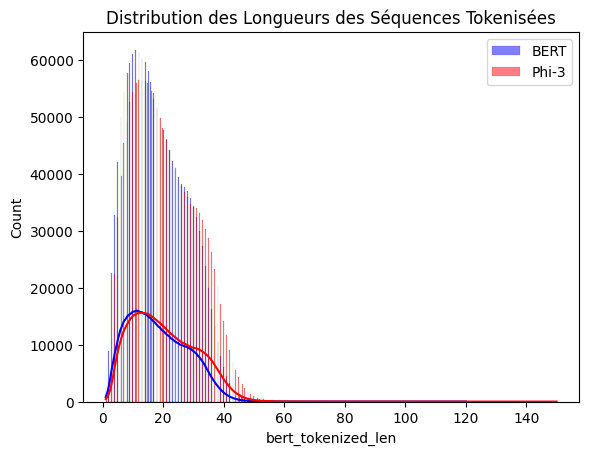

In [34]:
data['bert_tokenized_len'] = data['cleaned_text'].apply(lambda x: len(bert_tokenizer.tokenize(x)))
data['phi3_tokenized_len'] = data['cleaned_text'].apply(lambda x: len(phi3_tokenizer.tokenize(x)))

sns.histplot(data['bert_tokenized_len'], kde=True, color='blue', label='BERT')
sns.histplot(data['phi3_tokenized_len'], kde=True, color='red', label='Phi-3')
plt.legend()
plt.title('Distribution des Longueurs des S√©quences Tokenis√©es')
plt.show()

1. **Diff√©rences de Longueur des S√©quences** :
   - La distribution des longueurs des s√©quences pour BERT (en bleu) et Phi-3 (en rouge) montre que les s√©quences tokenis√©es par BERT tendent √† √™tre l√©g√®rement plus longues que celles tokenis√©es par Phi-3, en particulier dans les premiers intervalles.
   - Cela s'explique par la mani√®re dont chaque mod√®le effectue la tokenisation. BERT utilise une technique appel√©e "WordPiece tokenization," qui segmente les mots en sous-mots, ce qui peut parfois entra√Æner des s√©quences plus longues, surtout pour les mots peu communs ou les mots compos√©s.

2. **Pic de Distribution** :
   - Les deux distributions montrent un pic autour de 10 √† 20 tokens, ce qui sugg√®re que la majorit√© des tweets, apr√®s tokenisation, tombent dans cette plage de longueur pour les deux mod√®les. Cependant, la distribution de BERT semble avoir un pic l√©g√®rement plus marqu√©, ce qui peut indiquer qu'il g√©n√®re plus de tokens pour une majorit√© de tweets.
   - Phi-3, en utilisant une m√©thode de tokenisation plus proche de BPE (Byte-Pair Encoding), tend √† produire des s√©quences un peu plus courtes pour les m√™mes textes.

3. **Longueurs Extr√™mes** :
   - Les s√©quences les plus longues sont plus fr√©quentes avec BERT, ce qui peut √™tre d√ª √† son approche plus granulaire de la tokenisation. Phi-3, de son c√¥t√©, produit moins de s√©quences de longueur extr√™me.

In [35]:
# Calcul de la longueur maximale des s√©quences tokenis√©es pour BERT
max_bert_length = data['bert_tokenized_len'].max()

# Calcul de la longueur maximale des s√©quences tokenis√©es pour Phi-3
max_phi3_length = data['phi3_tokenized_len'].max()

# Affichage des r√©sultats
print(f"Longueur maximale d'un tweet tokenis√© par BERT : {max_bert_length}")
print(f"Longueur maximale d'un tweet tokenis√© par Phi-3 : {max_phi3_length}")

Longueur maximale d'un tweet tokenis√© par BERT : 120
Longueur maximale d'un tweet tokenis√© par Phi-3 : 150


## S√©paration Train/Test

In [2]:
data = pd.read_csv('./data/001/sentiment140_cleaned.csv')

In [ ]:
# class_proportions = data['target'].value_counts(normalize=True)
# n_classes = len(class_proportions)
# n_samples_per_class = 1000 // n_classes 

# sampled_data = data.groupby('target').apply(lambda x: x.sample(n=n_samples_per_class, random_state=42)).reset_index(drop=True)
# data = sampled_data

In [3]:
display(len(data[data['target'] == 0]))
display(len(data[data['target'] == 1]))

782114

770936

In [4]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['cleaned_text'], data['target'], test_size=0.2, random_state=42,stratify=data['target']
)

# Cr√©ation du Mod√®le BERT

## Initialisation

In [5]:
# Initialisation du tokenizer BERT avec ajout de tokens sp√©ciaux
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Ajouter des tokens sp√©ciaux pour les URLs, mentions et hashtags
special_tokens = {
    'additional_special_tokens': ['[URL]', '[MENTION]', '[HASHTAG]']
}

# Ajouter ces tokens sp√©ciaux au tokenizer
bert_tokenizer.add_special_tokens(special_tokens)

# Encoder les donn√©es d'entra√Ænement
encoder_train = bert_tokenizer.batch_encode_plus(
    train_texts.tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=200,
    return_tensors='pt'
)

# Encoder les donn√©es de test
encoder_test = bert_tokenizer.batch_encode_plus(
    test_texts.tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=200,
    return_tensors='pt'
)

/media/s8n/Jeux video/IA/sentiments/venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/media/s8n/Jeux video/IA/sentiments/venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a futu

In [6]:
# R√©cup√©rer les identifiants d'entr√©e et les masques d'attention pour l'entra√Ænement
input_ids_train = encoder_train['input_ids']
attention_masks_train = encoder_train["attention_mask"]
labels_train = torch.tensor(train_labels.values)

# R√©cup√©rer les identifiants d'entr√©e et les masques d'attention pour le test
input_ids_test = encoder_test['input_ids']
attention_masks_test = encoder_test["attention_mask"]
labels_test = torch.tensor(test_labels.values)

In [7]:
from torch.utils.data import TensorDataset

# Cr√©er des datasets Tensor pour l'entra√Ænement et le test
data_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
data_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)

# Afficher la longueur des datasets d'entra√Ænement et de test
len(data_train), len(data_test)

(1242440, 310610)

In [8]:
# Charger le mod√®le BERT pour la classification des s√©quences
bert_model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)

# Mettre √† jour le mod√®le pour reconna√Ætre les nouveaux tokens
bert_model.resize_token_embeddings(len(bert_tokenizer))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Embedding(30525, 768, padding_idx=0)

## D√©finition des Arguments d'Entra√Ænement

In [10]:
training_args = TrainingArguments(
    num_train_epochs=3,  # Nombre d'√©poques d'entra√Ænement
    output_dir='./results',  # R√©pertoire pour sauvegarder les r√©sultats
    evaluation_strategy="epoch",  # √âvaluer le mod√®le √† la fin de chaque √©poque
    save_strategy="epoch",  # Sauvegarder le mod√®le √† la fin de chaque √©poque
    learning_rate=2e-5,  # Taux d'apprentissage pour l'optimisation
    per_device_train_batch_size=4,  # R√©duire la taille du batch pour s'adapter √† 5Go de VRAM
    per_device_eval_batch_size=4,   # R√©duire la taille du batch pour s'adapter √† 5Go de VRAM
    weight_decay=0.01,  # D√©croissance du poids pour la r√©gularisation
    load_best_model_at_end=True,  # Charger le meilleur mod√®le √† la fin de l'entra√Ænement
    metric_for_best_model='eval_loss',  # Utiliser la perte d'√©valuation pour d√©terminer le meilleur mod√®le
    greater_is_better=False,  # Plus la perte est faible, meilleur est le mod√®le
    dataloader_num_workers=4,  # R√©duire le nombre de workers pour √©conomiser de la RAM
    fp16=True,  # Utiliser la pr√©cision mixte pour acc√©l√©rer l'entra√Ænement et √©conomiser de la VRAM
    gradient_accumulation_steps=4,  # Accumuler les gradients sur plusieurs √©tapes pour simuler un plus grand batch size
    resume_from_checkpoint=True,  # Reprendre l'entra√Ænement √† partir du checkpoint
    save_total_limit=5,  # Limiter le nombre de checkpoints sauvegard√©s √† 1 (le meilleur mod√®le)

    logging_steps=1000,  # Fr√©quence d'enregistrement des logs (tous les 10 batches)
    logging_strategy="epoch",  # Enregistrer les logs √† chaque √©poque
)

/media/s8n/Jeux video/IA/sentiments/venv/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of ü§ó Transformers. Use `eval_strategy` instead
  warnings.warn(


## Entra√Ænement

In [11]:
import torch

class SentimentDataset:
    """
    Classe utilis√©e pour cr√©er un collateur de batch pour un dataset de sentiments.

    Cette classe prend un tokenizer et une longueur maximale, et permet de formater les batches de donn√©es
    sous une forme pr√™te pour l'entra√Ænement.

    Attributs :
    ----------
    tokenizer : objet Tokenizer
        Le tokenizer utilis√© pour transformer les textes en tokens.
    max_length : int
        La longueur maximale des s√©quences de tokens. Toute s√©quence plus longue sera tronqu√©e.

    M√©thodes :
    --------
    __call__(self, batch):
        Prend un batch de donn√©es et retourne les `input_ids`, `attention_masks`, et `labels`,
        en les limitant √† la longueur maximale d√©finie.
    """
    
    def __init__(self, tokenizer, max_length=200):
        """
        Initialise la classe SentimentDataset.

        Param√®tres :
        ----------
        tokenizer : objet Tokenizer
            Le tokenizer utilis√© pour transformer les textes en tokens.
        max_length : int, optionnel
            La longueur maximale des s√©quences de tokens (par d√©faut 200).
        """
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __call__(self, batch):
        """
        Applique le collateur au batch fourni.

        Param√®tres :
        ----------
        batch : liste de tuples
            Chaque √©l√©ment du batch est un tuple contenant (input_ids, attention_mask, label).

        Retourne :
        --------
        dict :
            Un dictionnaire avec les cl√©s suivantes :
            - 'input_ids' : un tensor PyTorch contenant les `input_ids` des tokens pour chaque √©l√©ment du batch.
            - 'attention_mask' : un tensor PyTorch contenant les masques d'attention correspondants.
            - 'labels' : un tensor PyTorch des labels associ√©s √† chaque entr√©e du batch.
        """
        # Extraction des input_ids, attention_masks, et labels √† partir du batch
        input_ids = torch.stack([item[0] for item in batch])
        attention_masks = torch.stack([item[1] for item in batch])
        labels = torch.stack([item[2] for item in batch])
        
        # Tronquer les s√©quences √† la longueur maximale
        input_ids = input_ids[:, :self.max_length]
        attention_masks = attention_masks[:, :self.max_length]
        
        # Retourne un dictionnaire contenant les donn√©es pr√™tes pour le mod√®le
        return {
            'input_ids': input_ids,
            'attention_mask': attention_masks,
            'labels': labels
        }

# Cr√©ation du collateur pour traiter les batches de donn√©es sentimentales
sentiment_collator = SentimentDataset(tokenizer=bert_tokenizer, max_length=200)

In [12]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Cr√©ation d'un callback pour l'arr√™t anticip√© (early stopping)
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=3  # Nombre d'√©poques sans am√©lioration avant d'arr√™ter l'entra√Ænement
)

def compute_metrics(p):
    """
    Fonction pour calculer les m√©triques d'√©valuation lors de l'entra√Ænement d'un mod√®le.

    Cette fonction prend les pr√©dictions et les labels r√©els du batch et calcule les m√©triques suivantes :
    - Pr√©cision
    - Rappel
    - Score F1
    - Exactitude (Accuracy)

    Param√®tres :
    ----------
    p : EvalPrediction
        Un objet qui contient les pr√©dictions du mod√®le ainsi que les labels r√©els.

    Retourne :
    --------
    dict :
        Un dictionnaire contenant les m√©triques calcul√©es (accuracy, precision, recall, f1).
    """
    # Obtenir les pr√©dictions les plus probables (classes) √† partir des logits
    preds = p.predictions.argmax(-1)
    
    # Calcul des m√©triques de pr√©cision, rappel et F1 pour une classification binaire
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='binary')
    
    # Calcul de l'exactitude (accuracy)
    acc = accuracy_score(p.label_ids, preds)
    
    # Retourner les m√©triques sous forme de dictionnaire
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

# Configuration du formateur (Trainer) pour entra√Æner et √©valuer le mod√®le
trainer = Trainer(
    model=bert_model,                  # Le mod√®le BERT que l'on souhaite entra√Æner
    args=training_args,                # Arguments de configuration de l'entra√Ænement
    train_dataset=data_train,          # Dataset d'entra√Ænement
    eval_dataset=data_test,            # Dataset d'√©valuation
    data_collator=sentiment_collator,  # Collateur de donn√©es pour pr√©parer les batches
    compute_metrics=compute_metrics,   # Fonction pour calculer les m√©triques d'√©valuation
    callbacks=[early_stopping]         # Callback pour arr√™ter l'entra√Ænement si les performances cessent de s'am√©liorer
)


/media/s8n/Jeux video/IA/sentiments/venv/lib/python3.10/site-packages/accelerate/accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [13]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

trainer.train()

[2024-09-16 10:19:18,750] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/usr/bin/ld¬†: ne peut pas trouver -laio¬†: Aucun fichier ou dossier de ce nom
collect2: error: ld returned 1 exit status
/usr/bin/ld¬†: ne peut pas trouver -lcufile¬†: Aucun fichier ou dossier de ce nom
collect2: error: ld returned 1 exit status
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nicolas-poubelle (nicolas-poubelle-olicy). Use `wandb login --relogin` to force relogin


 33%|‚ñà‚ñà‚ñà‚ñé      | 77652/232956 [4:53:23<10:19:43,  4.18it/s]

{'loss': 0.333, 'grad_norm': 6.324601173400879, 'learning_rate': 1.3335737220762722e-05, 'epoch': 1.0}


                                                           
 33%|‚ñà‚ñà‚ñà‚ñé      | 77652/232956 [5:12:11<10:19:43,  4.18it/s]

{'eval_loss': 0.30709001421928406, 'eval_accuracy': 0.8686133736840411, 'eval_precision': 0.8953255646910326, 'eval_recall': 0.8326707180242173, 'eval_f1': 0.8628622506586375, 'eval_runtime': 1128.5992, 'eval_samples_per_second': 275.217, 'eval_steps_per_second': 68.805, 'epoch': 1.0}


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 155305/232956 [10:04:35<6:25:07,  3.36it/s]

{'loss': 0.2691, 'grad_norm': 6.060823917388916, 'learning_rate': 6.6715602946479175e-06, 'epoch': 2.0}


                                                            
 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 155305/232956 [10:23:17<6:25:07,  3.36it/s]

{'eval_loss': 0.31469303369522095, 'eval_accuracy': 0.8746498824892952, 'eval_precision': 0.8684385509507307, 'eval_recall': 0.880936784553821, 'eval_f1': 0.8746430215748584, 'eval_runtime': 1121.6191, 'eval_samples_per_second': 276.93, 'eval_steps_per_second': 69.233, 'epoch': 2.0}


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 232956/232956 [15:15:33<00:00,  4.11it/s]      

{'loss': 0.2147, 'grad_norm': 1.2867555618286133, 'learning_rate': 7.469221655591614e-09, 'epoch': 3.0}


                                                          
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 232956/232956 [15:34:15<00:00,  4.11it/s]

{'eval_loss': 0.3771897554397583, 'eval_accuracy': 0.8735134090982261, 'eval_precision': 0.8753372838280162, 'eval_recall': 0.8689448526788899, 'eval_f1': 0.8721293547883143, 'eval_runtime': 1121.5261, 'eval_samples_per_second': 276.953, 'eval_steps_per_second': 69.239, 'epoch': 3.0}


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 232956/232956 [15:34:17<00:00,  4.16it/s]

{'train_runtime': 56058.6452, 'train_samples_per_second': 66.49, 'train_steps_per_second': 4.156, 'train_loss': 0.2722710042347053, 'epoch': 3.0}


TrainOutput(global_step=232956, training_loss=0.2722710042347053, metrics={'train_runtime': 56058.6452, 'train_samples_per_second': 66.49, 'train_steps_per_second': 4.156, 'total_flos': 3.83083118827776e+17, 'train_loss': 0.2722710042347053, 'epoch': 2.999980683171823})

## Sauvegarde du Mod√®le BERT

In [14]:
# Apr√®s avoir fini l'entra√Ænement
trainer.save_model('./models/bert_model')

# Sauvegarder l'√©tat du mod√®le (si n√©cessaire)
trainer.save_state()

In [6]:
bert_tokenizer.save_pretrained('./models/bert_model')

('./models/bert_model/tokenizer_config.json',
 './models/bert_model/special_tokens_map.json',
 './models/bert_model/vocab.txt',
 './models/bert_model/added_tokens.json')

# √âvaluation du Mod√®le BERT

## √âvaluation

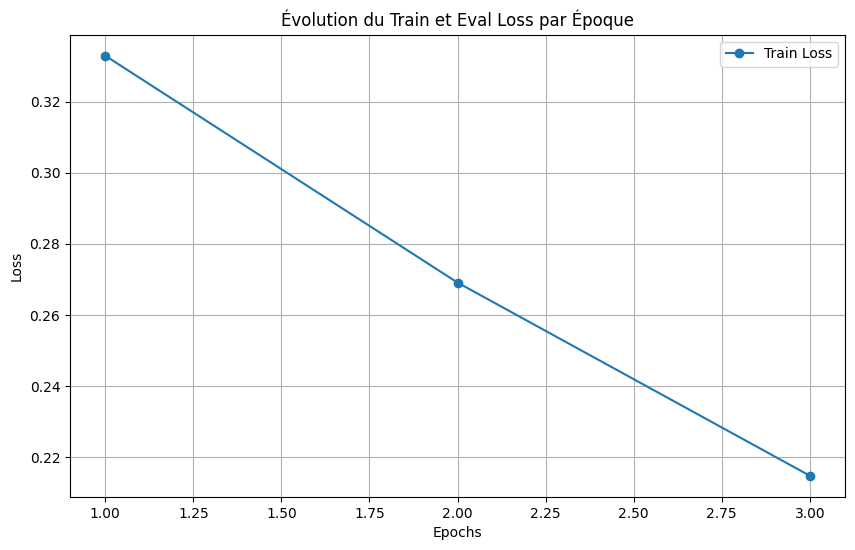

In [19]:
# R√©cup√©rer les logs d'entra√Ænement du Trainer
training_logs = trainer.state.log_history

# Cr√©er des listes pour stocker les valeurs de loss et des √©poques
epochs = []
train_loss = []
eval_loss = []

# Parcourir les logs pour r√©cup√©rer les valeurs de perte (loss) et d'√©valuation
for log in training_logs:
    # Si une √©poque et une perte d'entra√Ænement sont pr√©sentes, on les enregistre
    if 'epoch' in log and 'loss' in log:
        epochs.append(log['epoch'])
        train_loss.append(log['loss'])
    # Si une perte d'√©valuation est pr√©sente, on l'ajoute √† la liste correspondante
    if 'epoch' in log and 'eval_loss' in log:
        eval_loss.append(log['eval_loss'])

# Tracer le graphique de l'√©volution du loss
plt.figure(figsize=(10, 6))

# Tracer le loss d'entra√Ænement
plt.plot(epochs, train_loss, label='Train Loss', marker='o')

# Si eval_loss est disponible et a la m√™me longueur que epochs, tracer aussi
if len(eval_loss) == len(epochs):
    plt.plot(epochs, eval_loss, label='Eval Loss', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('√âvolution du Train et Eval Loss par √âpoque')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# √âvaluer le mod√®le pour obtenir les m√©triques
eval_results = trainer.evaluate(data_test)
print("Evaluation results:", eval_results)

# Sauvegarder les m√©triques
trainer.save_metrics('../metrics/bert_model', eval_results)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 77653/77653 [18:20<00:00, 70.55it/s]

Evaluation results: {'eval_loss': 0.30709001421928406, 'eval_accuracy': 0.8686133736840411, 'eval_precision': 0.8953255646910326, 'eval_recall': 0.8326707180242173, 'eval_f1': 0.8628622506586375, 'eval_runtime': 1101.2428, 'eval_samples_per_second': 282.054, 'eval_steps_per_second': 70.514, 'epoch': 2.999980683171823}


## Calcul des M√©triques

In [16]:
metric = load_metric("accuracy")
bert_model.eval()
predictions, label_ids, metrics = trainer.predict(data_test)

/tmp/ipykernel_2491137/3769951972.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library ü§ó Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
Using the latest cached version of the module from /home/s8n/.cache/huggingface/modules/datasets_modules/metrics/accuracy/9756d5fa4a0f9da966341741fc3926eafdc604b8276add51d5abbaa8958a25f9 (last modified on Fri Aug 30 11:05:30 2024) since it couldn't be found locally at accuracy, or remotely on the Hugging Face Hub.
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 77653/77653 [18:20<00:00, 70.54it/s]


In [17]:
accuracy = metric.compute(predictions=np.argmax(predictions, axis=1), references=label_ids)
print(f"Accuracy of BERT: {accuracy['accuracy']}")

Accuracy of BERT: 0.8686133736840411


### Confusion Matrix

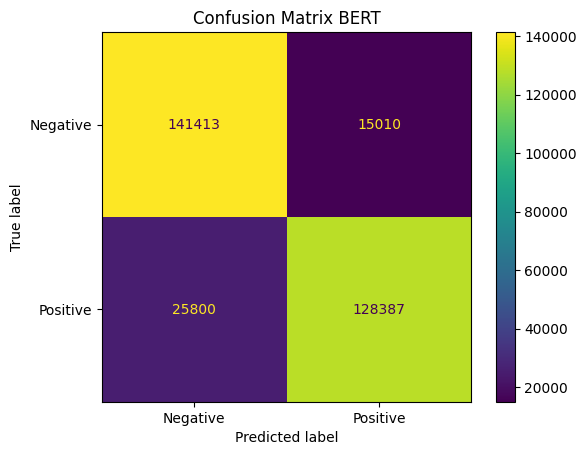

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(label_ids, np.argmax(predictions, axis=1))
ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Positive']).plot()
plt.title('Confusion Matrix BERT')
plt.show()

# Cr√©ation du Mod√®le Phi-3

## Initialisation

### Importation des biblioth√®ques n√©cessaires
Import des biblioth√®ques n√©cessaires pour charger les donn√©es, manipuler les mod√®les, et visualiser les r√©sultats.

In [1]:
import pandas as pd  # Manipulation des dataframes pour g√©rer les donn√©es des tweets
import torch  # Utilis√© pour la gestion du mod√®le et les tenseurs
from transformers import Phi3ForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, BitsAndBytesConfig  # Utilitaires pour le mod√®le Phi-3
from sklearn.model_selection import train_test_split  # Pour diviser les donn√©es en jeu d'entra√Ænement et de test
from peft import LoraConfig, TaskType, get_peft_model  # Pour int√©grer LoRA au mod√®le
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  # Pour calculer et afficher la matrice de confusion
import matplotlib.pyplot as plt  # Pour afficher les graphiques
import numpy as np  # Manipulation des tableaux de donn√©es
from datasets import load_metric  # Chargement des m√©triques pour √©valuer le mod√®le
import os  # Gestion des fichiers et du syst√®me
from huggingface_hub import login  # Pour authentification avec Hugging Face
from tqdm import tqdm  # Barre de progression pour suivre les processus longs

/media/s8n/Jeux video/IA/sentiments/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Chargement des donn√©es de tweets √† partir d'un fichier CSV
Ces donn√©es sont pr√©-trait√©es pour √™tre adapt√©es √† la t√¢che de classification

In [2]:
# Chargement des donn√©es
data = pd.read_csv('./data/001/sentiment140_cleaned.csv')

### √âquilibrage des classes (par exemple, m√™me nombre de classes positives et n√©gatives)
On prend un nombre d'exemples √©gal pour chaque classe afin d'√©viter un d√©s√©quilibre de classe.

Ce code est utile pendant les phases de test d'entrainement

In [3]:
# # √âquilibrage des classes
# class_proportions = data['target'].value_counts(normalize=True)
# n_classes = len(class_proportions)
# n_samples_per_class = 50000 // n_classes
# sampled_data = data.groupby('target').apply(lambda x: x.sample(n=n_samples_per_class, random_state=42)).reset_index(drop=True)
# data = sampled_data

### S√©paration du jeu de donn√©es en ensembles d'entra√Ænement et de test (80% pour l'entra√Ænement, 20% pour le test)

In [3]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['cleaned_text'], data['target'], test_size=0.2, random_state=42, stratify=data['target']
)

### Authentification Hugging Face avec un token API pour acc√©der aux mod√®les h√©berg√©s sur Hugging Face

In [4]:
login(token="xxxxxxxxx")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /home/s8n/.cache/huggingface/token
Login successful


## Configuration du Mod√®le et Quantification
Nous utilisons le mod√®le Phi-3 avec une quantification 4-bit pour optimiser la m√©moire.

In [5]:
# Configuration de BitsAndBytes pour utiliser une quantification 4-bit (r√©duction de la m√©moire et optimisation)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,  # Utilisation de la quantification 4-bit pour √©conomiser de la m√©moire
    bnb_4bit_quant_type="nf4",  # Type de quantification utilis√© : Normal-Four (nf4)
    bnb_4bit_use_double_quant=True,  # Activation de la double quantification pour plus d'efficacit√©
    bnb_4bit_compute_dtype=torch.float16  # Type de calcul utilis√© pour la quantification
)
# bnb_config = BitsAndBytesConfig(
#     load_in_8bit=True,  # Activer la quantification en 8 bits
#     bnb_8bit_compute_dtype=torch.float16  # Le type de donn√©es pour les calculs (ici float16 pour optimiser la m√©moire)
# )

# Chargement du mod√®le Phi3 pour la classification
model_name = "microsoft/Phi-3-mini-4k-instruct"  # Nom du mod√®le Phi3 sur HuggingFace

# Limitation de la m√©moire allou√©e pour le mod√®le sur GPU et CPU
max_memory = {
    0: "5GB",  # Limite m√©moire GPU
    "cpu": "25GB"  # Limite m√©moire CPU
}

# Chargement du mod√®le Phi-3 avec quantification 4-bit
model = Phi3ForSequenceClassification.from_pretrained(
    model_name,  # Mod√®le Phi-3 pr√©-entra√Æn√©
    quantization_config=bnb_config,  # Configuration de la quantification 4-bit
    device_map="auto",  # Attribution automatique aux dispositifs (GPU/CPU)
    num_labels=2,  # Deux classes (positif, n√©gatif)
    ignore_mismatched_sizes=True,  # Ignore les erreurs de taille de couches incompatibles
    max_memory=max_memory,  # Limites m√©moire pour GPU et CPU
    # offload_folder="offload",  # Dossier pour d√©charger les donn√©es si n√©cessaire
    # offload_state_dict=True,  # D√©chargement des poids pour √©conomiser de la m√©moire
    torch_dtype=torch.float16,  # Utilisation de float16 pour √©conomiser de la m√©moire
    low_cpu_mem_usage=True  # R√©duction de l'utilisation de la m√©moire CPU
)

# Chargement du tokenizer associ√© au mod√®le Phi3
tokenizer = AutoTokenizer.from_pretrained(model_name)

Loading checkpoint shards: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2/2 [00:13<00:00,  6.64s/it]
Some weights of Phi3ForSequenceClassification were not initialized from the model checkpoint at microsoft/Phi-3-mini-4k-instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# Afficher toutes les couches et leur type de pr√©cision avant LoRA
print("Avant LoRA :")
for name, param in model.named_parameters():
    print(f"Couche : {name} | Pr√©cision : {param.dtype}")

Avant LoRA :
Couche : model.embed_tokens.weight | Pr√©cision : torch.float16
Couche : model.layers.0.self_attn.o_proj.weight | Pr√©cision : torch.uint8
Couche : model.layers.0.self_attn.qkv_proj.weight | Pr√©cision : torch.uint8
Couche : model.layers.0.mlp.gate_up_proj.weight | Pr√©cision : torch.uint8
Couche : model.layers.0.mlp.down_proj.weight | Pr√©cision : torch.uint8
Couche : model.layers.0.input_layernorm.weight | Pr√©cision : torch.float16
Couche : model.layers.0.post_attention_layernorm.weight | Pr√©cision : torch.float16
Couche : model.layers.1.self_attn.o_proj.weight | Pr√©cision : torch.uint8
Couche : model.layers.1.self_attn.qkv_proj.weight | Pr√©cision : torch.uint8
Couche : model.layers.1.mlp.gate_up_proj.weight | Pr√©cision : torch.uint8
Couche : model.layers.1.mlp.down_proj.weight | Pr√©cision : torch.uint8
Couche : model.layers.1.input_layernorm.weight | Pr√©cision : torch.float16
Couche : model.layers.1.post_attention_layernorm.weight | Pr√©cision : torch.float16
Cou

In [7]:
# Afficher la structure du mod√®le
print(model)

Phi3ForSequenceClassification(
  (model): Phi3Model(
    (embed_tokens): Embedding(32064, 3072, padding_idx=32000)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x Phi3DecoderLayer(
        (self_attn): Phi3Attention(
          (o_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
          (qkv_proj): Linear4bit(in_features=3072, out_features=9216, bias=False)
          (rotary_emb): Phi3RotaryEmbedding()
        )
        (mlp): Phi3MLP(
          (gate_up_proj): Linear4bit(in_features=3072, out_features=16384, bias=False)
          (down_proj): Linear4bit(in_features=8192, out_features=3072, bias=False)
          (activation_fn): SiLU()
        )
        (input_layernorm): Phi3RMSNorm((3072,), eps=1e-05)
        (resid_attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_mlp_dropout): Dropout(p=0.0, inplace=False)
        (post_attention_layernorm): Phi3RMSNorm((3072,), eps=1e-05)
      )
    )
    (norm): Phi3RMS

## Pr√©traitement des Donn√©es : Tokenisation
es textes sont transform√©s en s√©quences de tokens utilisables par le mod√®le.

In [8]:
# Liste des tokens sp√©ciaux
special_tokens = {
    'additional_special_tokens': ['[URL]', '[MENTION]', '[HASHTAG]']
}

# Ajouter ces tokens sp√©ciaux au tokenizer
tokenizer.add_special_tokens(special_tokens)

# Mettre √† jour le mod√®le pour reconna√Ætre ces nouveaux tokens
model.resize_token_embeddings(len(tokenizer))

# Sp√©cifier un token de padding si non d√©fini dans le tokenizer
tokenizer.pad_token = tokenizer.eos_token

# Fonction pour tokeniser les textes par lots
def batch_tokenize(texts, tokenizer, batch_size=10000, max_length=200):
    """
    Tokenisation par lots des textes pour une meilleure gestion de la m√©moire.
    
    Args:
        texts (list): Liste des textes √† tokeniser.
        tokenizer (AutoTokenizer): Tokenizer associ√© au mod√®le.
        batch_size (int): Taille du lot de textes √† tokeniser.
        max_length (int): Longueur maximale des s√©quences apr√®s tokenisation.
        
    Returns:
        dict: Contient les tokens 'input_ids' et 'attention_mask'.
    """
    encodings = {'input_ids': [], 'attention_mask': []}  # Initialisation des encodages

    # Tokenisation en lots
    for i in tqdm(range(0, len(texts), batch_size), desc="Tokenisation", unit="batch"):
        batch_texts = texts[i:i+batch_size]  # S√©lection d'un lot de textes
        batch_encodings = tokenizer.batch_encode_plus(
            batch_texts,
            padding='max_length',  # Ajout de padding pour les s√©quences courtes
            truncation=True,  # Tronquer les textes plus longs que la longueur maximale
            max_length=max_length,  # Longueur maximale des s√©quences
            add_special_tokens=True,  # Ajout des tokens sp√©ciaux pour d√©but et fin de s√©quence
            return_tensors="pt"  # Retour sous forme de tenseurs PyTorch
        )
        encodings['input_ids'].append(batch_encodings['input_ids'])
        encodings['attention_mask'].append(batch_encodings['attention_mask'])
    
    # Concatenation des encodages pour chaque lot
    encodings['input_ids'] = torch.cat(encodings['input_ids'])
    encodings['attention_mask'] = torch.cat(encodings['attention_mask'])
    
    return encodings

# Tokenisation des textes d'entra√Ænement
train_encodings = batch_tokenize(list(train_texts), tokenizer, batch_size=10000, max_length=200)

# Tokenisation des textes de test
test_encodings = batch_tokenize(list(test_texts), tokenizer, batch_size=10000, max_length=200)

Tokenisation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:22<00:00,  1.43batch/s]


In [9]:
print("Taille du vocabulaire du tokenizer :", len(tokenizer))

Taille du vocabulaire du tokenizer : 32014


## Cr√©ation du Dataset pour le Mod√®le
Transformation des donn√©es tokenis√©es en Dataset PyTorch pour l'entra√Ænement et le test.

In [10]:
class SentimentDataset(torch.utils.data.Dataset):
    """
    Classe repr√©sentant un Dataset pour l'analyse de sentiment.
    
    Cette classe est utilis√©e pour cr√©er un Dataset compatible avec PyTorch, o√π les textes ont √©t√©
    tokenis√©s et chaque texte est associ√© √† une √©tiquette de sentiment (0 pour n√©gatif, 1 pour positif).
    
    Args:
    -----
        encodings (dict): Dictionnaire contenant les encodages 'input_ids' et 'attention_mask'.
        labels (list): Liste des √©tiquettes (0 pour n√©gatif, 1 pour positif).
    
    Methods:
    --------
        __getitem__(idx): Retourne un item encod√© (s√©quences tokenis√©es) et son label associ√©.
        __len__(): Retourne la taille du dataset, c'est-√†-dire le nombre total d'√©l√©ments.
    """
    
    def __init__(self, encodings, labels):
        """
        Initialise le Dataset avec les encodages et les √©tiquettes de sentiment.
        
        Args:
        -----
            encodings (dict): Dictionnaire contenant les encodages tokenis√©s ('input_ids', 'attention_mask').
            labels (list): Liste des √©tiquettes (0 pour n√©gatif, 1 pour positif).
        """
        # Initialisation des encodages des textes et des labels associ√©s
        self.encodings = encodings  # Textes tokenis√©s sous forme de dictionnaire
        self.labels = labels  # Liste des √©tiquettes de sentiment

    def __getitem__(self, idx):
        """
        Retourne un √©l√©ment du dataset √† l'index donn√©, incluant les encodages et le label.
        
        Args:
        -----
            idx (int): Index de l'√©l√©ment √† retourner.
        
        Returns:
        --------
            dict: Un dictionnaire contenant les encodages ('input_ids', 'attention_mask') et le label correspondant.
        """
        # Cr√©ation d'un item en clonant et d√©tachant les tenseurs pour √©viter des modifications non d√©sir√©es
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        # Ajout de l'√©tiquette (label) comme un tenseur
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        """
        Retourne la taille du dataset, c'est-√†-dire le nombre total d'√©l√©ments dans celui-ci.
        
        Returns:
        --------
            int: Le nombre total d'√©chantillons (√©l√©ments) dans le dataset.
        """
        # Retourne le nombre d'√©tiquettes, ce qui correspond √† la taille du dataset
        return len(self.labels)

# Cr√©ation des datasets pour l'entra√Ænement et le test √† partir des encodages et des labels
train_dataset = SentimentDataset(train_encodings, list(train_labels))
test_dataset = SentimentDataset(test_encodings, list(test_labels))

## Application de LoRA pour l'Adaptation Fine-Tuning
LoRA (Low-Rank Adaptation) est utilis√© pour appliquer des modifications sp√©cifiques aux couches du mod√®le, ce qui permet un fine-tuning plus rapide et plus efficace avec une consommation de m√©moire r√©duite.


In [11]:
# Inspection des modules du mod√®le Phi-3
for name, module in model.named_modules():
    print(name)


model
model.embed_tokens
model.embed_dropout
model.layers
model.layers.0
model.layers.0.self_attn
model.layers.0.self_attn.o_proj
model.layers.0.self_attn.qkv_proj
model.layers.0.self_attn.rotary_emb
model.layers.0.mlp
model.layers.0.mlp.gate_up_proj
model.layers.0.mlp.down_proj
model.layers.0.mlp.activation_fn
model.layers.0.input_layernorm
model.layers.0.resid_attn_dropout
model.layers.0.resid_mlp_dropout
model.layers.0.post_attention_layernorm
model.layers.1
model.layers.1.self_attn
model.layers.1.self_attn.o_proj
model.layers.1.self_attn.qkv_proj
model.layers.1.self_attn.rotary_emb
model.layers.1.mlp
model.layers.1.mlp.gate_up_proj
model.layers.1.mlp.down_proj
model.layers.1.mlp.activation_fn
model.layers.1.input_layernorm
model.layers.1.resid_attn_dropout
model.layers.1.resid_mlp_dropout
model.layers.1.post_attention_layernorm
model.layers.2
model.layers.2.self_attn
model.layers.2.self_attn.o_proj
model.layers.2.self_attn.qkv_proj
model.layers.2.self_attn.rotary_emb
model.layers.

In [12]:
# D√©finition des modules du mod√®le sur lesquels appliquer LoRA
# Option 1 : Si seulement le ciblage des blocs d'attention du mod√®le
target_modules_attention = [
    "layers.0.self_attn.qkv_proj",
    "layers.0.self_attn.o_proj",
    "layers.1.self_attn.qkv_proj",
    "layers.1.self_attn.o_proj",
    "layers.2.self_attn.qkv_proj",
    "layers.2.self_attn.o_proj",
    "layers.3.self_attn.qkv_proj",
    "layers.3.self_attn.o_proj",
    "layers.4.self_attn.qkv_proj",
    "layers.4.self_attn.o_proj",
    "layers.5.self_attn.qkv_proj",
    "layers.5.self_attn.o_proj",
    "layers.6.self_attn.qkv_proj",
    "layers.6.self_attn.o_proj",
    "layers.7.self_attn.qkv_proj",
    "layers.7.self_attn.o_proj",
    "layers.8.self_attn.qkv_proj",
    "layers.8.self_attn.o_proj",
    "layers.9.self_attn.qkv_proj",
    "layers.9.self_attn.o_proj",
    "layers.10.self_attn.qkv_proj",
    "layers.10.self_attn.o_proj",
    "layers.11.self_attn.qkv_proj",
    "layers.11.self_attn.o_proj",
    "layers.12.self_attn.qkv_proj",
    "layers.12.self_attn.o_proj",
    "layers.13.self_attn.qkv_proj",
    "layers.13.self_attn.o_proj",
    "layers.14.self_attn.qkv_proj",
    "layers.14.self_attn.o_proj",
    "layers.15.self_attn.qkv_proj",
    "layers.15.self_attn.o_proj",
    "layers.16.self_attn.qkv_proj",
    "layers.16.self_attn.o_proj",
    "layers.17.self_attn.qkv_proj",
    "layers.17.self_attn.o_proj",
    "layers.18.self_attn.qkv_proj",
    "layers.18.self_attn.o_proj",
    "layers.19.self_attn.qkv_proj",
    "layers.19.self_attn.o_proj",
    "layers.20.self_attn.qkv_proj",
    "layers.20.self_attn.o_proj",
    "layers.21.self_attn.qkv_proj",
    "layers.21.self_attn.o_proj",
    "layers.22.self_attn.qkv_proj",
    "layers.22.self_attn.o_proj",
    "layers.23.self_attn.qkv_proj",
    "layers.23.self_attn.o_proj",
    "layers.24.self_attn.qkv_proj",
    "layers.24.self_attn.o_proj",
    "layers.25.self_attn.qkv_proj",
    "layers.25.self_attn.o_proj",
    "layers.26.self_attn.qkv_proj",
    "layers.26.self_attn.o_proj",
    "layers.27.self_attn.qkv_proj",
    "layers.27.self_attn.o_proj",
    "layers.28.self_attn.qkv_proj",
    "layers.28.self_attn.o_proj",
    "layers.29.self_attn.qkv_proj",
    "layers.29.self_attn.o_proj",
    "layers.30.self_attn.qkv_proj",
    "layers.30.self_attn.o_proj",
    "layers.31.self_attn.qkv_proj",
    "layers.31.self_attn.o_proj"
]

# Option 2 : Si l'on vise toutes les couches lin√©aires
target_modules_linear = [
    "layers.0.self_attn.qkv_proj",
    "layers.0.self_attn.o_proj",
    "layers.0.mlp.gate_up_proj",
    "layers.0.mlp.down_proj",
    "layers.1.self_attn.qkv_proj",
    "layers.1.self_attn.o_proj",
    "layers.1.mlp.gate_up_proj",
    "layers.1.mlp.down_proj",
    "layers.2.self_attn.qkv_proj",
    "layers.2.self_attn.o_proj",
    "layers.2.mlp.gate_up_proj",
    "layers.2.mlp.down_proj",
    "layers.3.self_attn.qkv_proj",
    "layers.3.self_attn.o_proj",
    "layers.3.mlp.gate_up_proj",
    "layers.3.mlp.down_proj",
    "layers.4.self_attn.qkv_proj",
    "layers.4.self_attn.o_proj",
    "layers.4.mlp.gate_up_proj",
    "layers.4.mlp.down_proj",
    "layers.5.self_attn.qkv_proj",
    "layers.5.self_attn.o_proj",
    "layers.5.mlp.gate_up_proj",
    "layers.5.mlp.down_proj",
    "layers.6.self_attn.qkv_proj",
    "layers.6.self_attn.o_proj",
    "layers.6.mlp.gate_up_proj",
    "layers.6.mlp.down_proj",
    "layers.7.self_attn.qkv_proj",
    "layers.7.self_attn.o_proj",
    "layers.7.mlp.gate_up_proj",
    "layers.7.mlp.down_proj",
    "layers.8.self_attn.qkv_proj",
    "layers.8.self_attn.o_proj",
    "layers.8.mlp.gate_up_proj",
    "layers.8.mlp.down_proj",
    "layers.9.self_attn.qkv_proj",
    "layers.9.self_attn.o_proj",
    "layers.9.mlp.gate_up_proj",
    "layers.9.mlp.down_proj",
    "layers.10.self_attn.qkv_proj",
    "layers.10.self_attn.o_proj",
    "layers.10.mlp.gate_up_proj",
    "layers.10.mlp.down_proj",
    "layers.11.self_attn.qkv_proj",
    "layers.11.self_attn.o_proj",
    "layers.11.mlp.gate_up_proj",
    "layers.11.mlp.down_proj",
    "layers.12.self_attn.qkv_proj",
    "layers.12.self_attn.o_proj",
    "layers.12.mlp.gate_up_proj",
    "layers.12.mlp.down_proj",
    "layers.13.self_attn.qkv_proj",
    "layers.13.self_attn.o_proj",
    "layers.13.mlp.gate_up_proj",
    "layers.13.mlp.down_proj",
    "layers.14.self_attn.qkv_proj",
    "layers.14.self_attn.o_proj",
    "layers.14.mlp.gate_up_proj",
    "layers.14.mlp.down_proj",
    "layers.15.self_attn.qkv_proj",
    "layers.15.self_attn.o_proj",
    "layers.15.mlp.gate_up_proj",
    "layers.15.mlp.down_proj",
    "layers.16.self_attn.qkv_proj",
    "layers.16.self_attn.o_proj",
    "layers.16.mlp.gate_up_proj",
    "layers.16.mlp.down_proj",
    "layers.17.self_attn.qkv_proj",
    "layers.17.self_attn.o_proj",
    "layers.17.mlp.gate_up_proj",
    "layers.17.mlp.down_proj",
    "layers.18.self_attn.qkv_proj",
    "layers.18.self_attn.o_proj",
    "layers.18.mlp.gate_up_proj",
    "layers.18.mlp.down_proj",
    "layers.19.self_attn.qkv_proj",
    "layers.19.self_attn.o_proj",
    "layers.19.mlp.gate_up_proj",
    "layers.19.mlp.down_proj",
    "layers.20.self_attn.qkv_proj",
    "layers.20.self_attn.o_proj",
    "layers.20.mlp.gate_up_proj",
    "layers.20.mlp.down_proj",
    "layers.21.self_attn.qkv_proj",
    "layers.21.self_attn.o_proj",
    "layers.21.mlp.gate_up_proj",
    "layers.21.mlp.down_proj",
    "layers.22.self_attn.qkv_proj",
    "layers.22.self_attn.o_proj",
    "layers.22.mlp.gate_up_proj",
    "layers.22.mlp.down_proj",
    "layers.23.self_attn.qkv_proj",
    "layers.23.self_attn.o_proj",
    "layers.23.mlp.gate_up_proj",
    "layers.23.mlp.down_proj",
    "layers.24.self_attn.qkv_proj",
    "layers.24.self_attn.o_proj",
    "layers.24.mlp.gate_up_proj",
    "layers.24.mlp.down_proj",
    "layers.25.self_attn.qkv_proj",
    "layers.25.self_attn.o_proj",
    "layers.25.mlp.gate_up_proj",
    "layers.25.mlp.down_proj",
    "layers.26.self_attn.qkv_proj",
    "layers.26.self_attn.o_proj",
    "layers.26.mlp.gate_up_proj",
    "layers.26.mlp.down_proj",
    "layers.27.self_attn.qkv_proj",
    "layers.27.self_attn.o_proj",
    "layers.27.mlp.gate_up_proj",
    "layers.27.mlp.down_proj",
    "layers.28.self_attn.qkv_proj",
    "layers.28.self_attn.o_proj",
    "layers.28.mlp.gate_up_proj",
    "layers.28.mlp.down_proj",
    "layers.29.self_attn.qkv_proj",
    "layers.29.self_attn.o_proj",
    "layers.29.mlp.gate_up_proj",
    "layers.29.mlp.down_proj",
    "layers.30.self_attn.qkv_proj",
    "layers.30.self_attn.o_proj",
    "layers.30.mlp.gate_up_proj",
    "layers.30.mlp.down_proj",
    "layers.31.self_attn.qkv_proj",
    "layers.31.self_attn.o_proj",
    "layers.31.mlp.gate_up_proj",
    "layers.31.mlp.down_proj"
]

# S√©lection des modules cibles (attention ou lin√©aires selon l'objectif)
target_modules = target_modules_attention 
# target_modules = target_modules_linear 

In [13]:
# Configuration de LoRA avec des param√®tres sp√©cifiques pour l'adaptation du mod√®le
lora_config = LoraConfig(
    r=16,  # Taille du rang de la d√©composition LoRA (16)
    lora_alpha=32,  # Facteur d'√©chelle pour LoRA
    lora_dropout=0.05,  # Taux de dropout appliqu√© aux poids LoRA pour √©viter l'overfitting
    task_type=TaskType.SEQ_CLS,  # Type de t√¢che : classification de s√©quence
    inference_mode=False,  # Indique que LoRA est utilis√© pour l'entra√Ænement (non pour l'inf√©rence)
    bias="none",  # Pas de biais ajout√©
    target_modules=target_modules,  # Couches cibles o√π appliquer LoRA
)

# Application de LoRA au mod√®le Phi3 charg√© pr√©c√©demment
model = get_peft_model(model, lora_config)

# Activation du gradient checkpointing pour r√©duire l'empreinte m√©moire pendant l'entra√Ænement
model.gradient_checkpointing_enable()

In [14]:
# Affichage des param√®tres entra√Ænables dans le mod√®le apr√®s application de LoRA
model.print_trainable_parameters()

trainable params: 9,443,328 || all params: 3,731,874,816 || trainable%: 0.2530


In [15]:
# Afficher les couches et leur type de pr√©cision apr√®s application de LoRA
print("\nApr√®s LoRA :")
for name, param in model.named_parameters():
    if "lora" in name:
        print(f"Couche LoRA : {name} | Pr√©cision : {param.dtype}")
    else:
        print(f"Couche : {name} | Pr√©cision : {param.dtype}")


Apr√®s LoRA :
Couche : base_model.model.model.embed_tokens.weight | Pr√©cision : torch.float16
Couche : base_model.model.model.layers.0.self_attn.o_proj.base_layer.weight | Pr√©cision : torch.uint8
Couche LoRA : base_model.model.model.layers.0.self_attn.o_proj.lora_A.default.weight | Pr√©cision : torch.float32
Couche LoRA : base_model.model.model.layers.0.self_attn.o_proj.lora_B.default.weight | Pr√©cision : torch.float32
Couche : base_model.model.model.layers.0.self_attn.qkv_proj.base_layer.weight | Pr√©cision : torch.uint8
Couche LoRA : base_model.model.model.layers.0.self_attn.qkv_proj.lora_A.default.weight | Pr√©cision : torch.float32
Couche LoRA : base_model.model.model.layers.0.self_attn.qkv_proj.lora_B.default.weight | Pr√©cision : torch.float32
Couche : base_model.model.model.layers.0.mlp.gate_up_proj.weight | Pr√©cision : torch.uint8
Couche : base_model.model.model.layers.0.mlp.down_proj.weight | Pr√©cision : torch.uint8
Couche : base_model.model.model.layers.0.input_layernor

In [16]:
# Afficher la structure du mod√®le
print(model)

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): Phi3ForSequenceClassification(
      (model): Phi3Model(
        (embed_tokens): Embedding(32014, 3072, padding_idx=32000)
        (embed_dropout): Dropout(p=0.0, inplace=False)
        (layers): ModuleList(
          (0-31): 32 x Phi3DecoderLayer(
            (self_attn): Phi3Attention(
              (o_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=3072, out_features=3072, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=3072, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=3072, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()


## D√©finition des Arguments d'Entra√Ænement

In [17]:
from datetime import datetime
# G√©n√®re un horodatage unique pour chaque entra√Ænement
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")

# Ajouter cet horodatage au r√©pertoire de logs
logging_dir = f"./logs/tensorboard_{current_time}"

# Configuration des arguments d'entra√Ænement pour le Trainer de Hugging Face
training_args = TrainingArguments(
    num_train_epochs=3,  # Nombre d'√©poques pour l'entra√Ænement
    output_dir='./results',  # R√©pertoire pour sauvegarder les r√©sultats du mod√®le
    learning_rate=2e-5,  # Taux d'apprentissage utilis√© par l'optimiseur
    per_device_train_batch_size=32,  # Taille du batch pour l'entra√Ænement
    per_device_eval_batch_size=4,  # Taille du batch pour l'√©valuation
    gradient_accumulation_steps=32,  # Accumulation des gradients sur 32 √©tapes avant de faire une mise √† jour des poids
    optim="paged_adamw_32bit",  # Optimiseur AdamW utilisant des poids en 32-bit ('adamw_hf', 'adamw_torch', 'adamw_torch_fused', 'adamw_torch_xla', 'adamw_torch_npu_fused', 'adamw_apex_fused', 'adafactor', 'adamw_anyprecision', 'sgd', 'adagrad', 'adamw_bnb_8bit', 'adamw_8bit', 'lion_8bit', 'lion_32bit', 'paged_adamw_32bit', 'paged_adamw_8bit', 'paged_lion_32bit', 'paged_lion_8bit', 'rmsprop', 'rmsprop_bnb', 'rmsprop_bnb_8bit', 'rmsprop_bnb_32bit', 'galore_adamw', 'galore_adamw_8bit', 'galore_adafactor', 'galore_adamw_layerwise', 'galore_adamw_8bit_layerwise', 'galore_adafactor_layerwise', 'lomo', 'adalomo')
    weight_decay=0.01,  # Taux de d√©croissance de poids pour √©viter le surapprentissage
    logging_steps=1000,  # Fr√©quence d'enregistrement des logs (tous les 10 batches)
    logging_strategy="epoch",  # Enregistrer les logs √† chaque √©poque
    evaluation_strategy="epoch",  # Effectuer une √©valuation √† chaque √©poque
    save_strategy="epoch",
    load_best_model_at_end=True,  # Charger le meilleur mod√®le √† la fin de l'entra√Ænement
    metric_for_best_model='eval_loss',  # Crit√®re pour d√©finir le meilleur mod√®le
    greater_is_better=False,  # Indique si une plus grande valeur de la m√©trique est meilleure (ici non)
    dataloader_num_workers=10,  # Nombre de workers pour charger les donn√©es

    report_to="tensorboard",  # Activer TensorBoard pour le suivi
    logging_dir=logging_dir,  # R√©pertoire pour les fichiers de logs (tensorboard --logdir=./logs)

    # Ajout des options pour le scheduler
    lr_scheduler_type='cosine_with_restarts',  # Type de scheduler ('cosine', 'constant','linear','cosine_with_restarts')
    warmup_steps=1000  # Nombre d'√©tapes de warm-up pour stabiliser l'apprentissage au d√©but de l'entra√Ænement
)

/media/s8n/Jeux video/IA/sentiments/venv/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of ü§ó Transformers. Use `eval_strategy` instead
  warnings.warn(


## Entra√Ænement du Mod√®le

In [18]:
# Initialisation du Trainer de Hugging Face avec les arguments et les datasets
trainer = Trainer(
    model=model,  # Mod√®le Phi3 avec LoRA
    args=training_args,  # Arguments d'entra√Ænement
    train_dataset=train_dataset,  # Dataset d'entra√Ænement
    eval_dataset=test_dataset,  # Dataset de test
    tokenizer=tokenizer,  # Tokenizer utilis√© pour l'encodage des textes
)

In [19]:
# D√©sactiver la parall√©lisation de tokenisation pour √©viter les erreurs sur certaines configurations
os.environ["TOKENIZERS_PARALLELISM"] = "false"

### Lib√©ration de la m√©moire CUDA
Je lib√®re la m√©moire GPU avant de lancer l'entra√Ænement pour √©viter toute erreur li√©e √† la saturation de la m√©moire.

In [20]:
# Lib√©ration de la m√©moire avec les fonctions garbage collector et vidage de cache CUDA
import gc  # Garbage collector pour lib√©rer la m√©moire
gc.collect()  # Lib√©rer la m√©moire Python
torch.cuda.empty_cache()  # Vider la m√©moire CUDA

In [21]:
# Entra√Ænement du mod√®le
trainer.train()

[2024-09-09 10:13:00,410] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/usr/bin/ld¬†: ne peut pas trouver -laio¬†: Aucun fichier ou dossier de ce nom
collect2: error: ld returned 1 exit status
/usr/bin/ld¬†: ne peut pas trouver -lcufile¬†: Aucun fichier ou dossier de ce nom
collect2: error: ld returned 1 exit status
  0%|          | 0/3639 [00:00<?, ?it/s]`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/media/s8n/Jeux video/IA/sentiments/venv/lib/python3.10/site-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
You are not running the flash-attention implementation, expect numerical differences.
 33%|‚ñà‚ñà‚ñà‚ñé      | 1213/3639 [29:44:15<60:41:31, 90.06s/it]

{'loss': 0.6813, 'grad_norm': 3.328125, 'learning_rate': 1.9680241573182663e-05, 'epoch': 1.0}


We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)
                                                         
 33%|‚ñà‚ñà‚ñà‚ñé      | 1213/3639 [39:09:07<60:41:31, 90.06s/it]/media/s8n/Jeux video/IA/sentiments/venv/lib/python3.10/site-packages/peft/utils/other.py:619: UserWarning: Unable to fetch remote file due to the following error (MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /microsoft/Phi-3-mini-4k-instruct/resolve/main/config.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7d37804e4640>: Failed to resolve \'huggingface.co\' ([Errno -3] Temporary failure in name resolution)"))'), '(Request ID: d3268278-5148-436d-bc38-0c16befbe69b)') - silently ignoring the lookup for the file config.json 

{'eval_loss': 0.5009765625, 'eval_runtime': 33891.5831, 'eval_samples_per_second': 9.165, 'eval_steps_per_second': 2.291, 'epoch': 1.0}


/media/s8n/Jeux video/IA/sentiments/venv/lib/python3.10/site-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 2426/3639 [69:31:41<30:15:12, 89.79s/it]     

{'loss': 0.4702, 'grad_norm': 1.62109375, 'learning_rate': 8.7355664769998e-06, 'epoch': 2.0}


                                                         
 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 2426/3639 [78:54:29<30:15:12, 89.79s/it]/media/s8n/Jeux video/IA/sentiments/venv/lib/python3.10/site-packages/peft/utils/other.py:619: UserWarning: Unable to fetch remote file due to the following error (MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /microsoft/Phi-3-mini-4k-instruct/resolve/main/config.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7d38c98c1960>: Failed to resolve \'huggingface.co\' ([Errno -3] Temporary failure in name resolution)"))'), '(Request ID: c4152140-e2ea-4afc-bf34-b3b0301304a5)') - silently ignoring the lookup for the file config.json in microsoft/Phi-3-mini-4k-instruct.
  warnings.warn(
/media/s8n/Jeux video/IA/sentiments/venv/lib/python3.10/site-packages/peft/utils/save_and_load.py:218: UserWarning: Could not find a config file in microsoft/Phi-3-mini-4k-instruct - will assume

{'eval_loss': 0.456787109375, 'eval_runtime': 33767.6285, 'eval_samples_per_second': 9.198, 'eval_steps_per_second': 2.3, 'epoch': 2.0}


/media/s8n/Jeux video/IA/sentiments/venv/lib/python3.10/site-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3639/3639 [108:04:02<00:00, 85.03s/it]       /media/s8n/Jeux video/IA/sentiments/venv/lib/python3.10/site-packages/peft/utils/save_and_load.py:232: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3639/3639 [108:04:03<00:00, 85.03s/it]

{'loss': 0.4533, 'grad_norm': 1.23828125, 'learning_rate': 0.0, 'epoch': 3.0}


                                                       
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3639/3639 [116:54:07<00:00, 85.03s/it]

{'eval_loss': 0.454345703125, 'eval_runtime': 31804.1249, 'eval_samples_per_second': 9.766, 'eval_steps_per_second': 2.442, 'epoch': 3.0}


/media/s8n/Jeux video/IA/sentiments/venv/lib/python3.10/site-packages/peft/utils/save_and_load.py:232: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3639/3639 [116:54:08<00:00, 115.65s/it]

{'train_runtime': 420848.0937, 'train_samples_per_second': 8.857, 'train_steps_per_second': 0.009, 'train_loss': 0.5349529336592299, 'epoch': 3.0}


TrainOutput(global_step=3639, training_loss=0.5349529336592299, metrics={'train_runtime': 420848.0937, 'train_samples_per_second': 8.857, 'train_steps_per_second': 0.009, 'total_flos': 1.6247485282340045e+19, 'train_loss': 0.5349529336592299, 'epoch': 2.9991500759780565})

## Sauvegarde du Mod√®le Fine-tun√©

In [22]:
# Sauvegarde du LoRA et de son √©tat pour une utilisation ult√©rieure
trainer.save_model('./models/phi3_model')  # Sauvegarde du LoRA
trainer.save_state()  # Sauvegarde de l'√©tat de l'entra√Ænement

/media/s8n/Jeux video/IA/sentiments/venv/lib/python3.10/site-packages/peft/utils/save_and_load.py:232: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


In [21]:
tokenizer.save_pretrained('./models/phi3_model')

('./models/phi3_model/tokenizer_config.json',
 './models/phi3_model/special_tokens_map.json',
 './models/phi3_model/tokenizer.model',
 './models/phi3_model/added_tokens.json',
 './models/phi3_model/tokenizer.json')

# √âvaluation du Mod√®le Phi-3

## Visualisation de l'√©volution du Loss pendant l'entra√Ænement

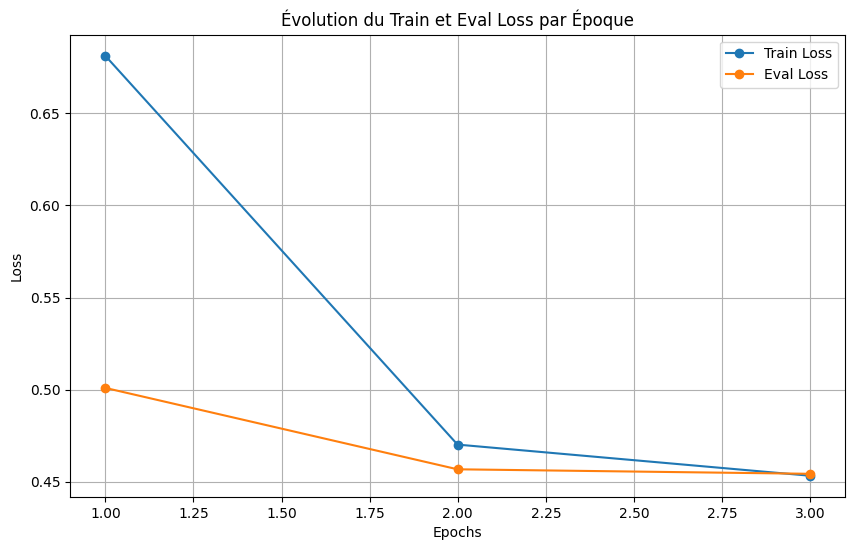

In [23]:
# R√©cup√©rer les logs d'entra√Ænement du Trainer
training_logs = trainer.state.log_history

# Cr√©er des listes pour stocker les valeurs de loss et des √©poques
epochs = []
train_loss = []
eval_loss = []

# Parcourir les logs pour r√©cup√©rer les valeurs de perte (loss) et d'√©valuation
for log in training_logs:
    # Si une √©poque et une perte d'entra√Ænement sont pr√©sentes, on les enregistre
    if 'epoch' in log and 'loss' in log:
        epochs.append(log['epoch'])
        train_loss.append(log['loss'])
    # Si une perte d'√©valuation est pr√©sente, on l'ajoute √† la liste correspondante
    if 'epoch' in log and 'eval_loss' in log:
        eval_loss.append(log['eval_loss'])

# Tracer le graphique de l'√©volution du loss
plt.figure(figsize=(10, 6))

# Tracer le loss d'entra√Ænement
plt.plot(epochs, train_loss, label='Train Loss', marker='o')

# Si eval_loss est disponible et a la m√™me longueur que epochs, tracer aussi
if len(eval_loss) == len(epochs):
    plt.plot(epochs, eval_loss, label='Eval Loss', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('√âvolution du Train et Eval Loss par √âpoque')
plt.legend()
plt.grid(True)
plt.show()

## √âvaluation sur le Jeu de Test

In [24]:
# √âvaluation du mod√®le sur l'ensemble de test
eval_results = trainer.evaluate(test_dataset)

# Affichage des r√©sultats de l'√©valuation
print("R√©sultats de l'√©valuation :", eval_results)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 77653/77653 [8:49:36<00:00,  2.44it/s]  

R√©sultats de l'√©valuation : {'eval_loss': 0.454345703125, 'eval_runtime': 31778.3375, 'eval_samples_per_second': 9.774, 'eval_steps_per_second': 2.444, 'epoch': 2.9991500759780565}


## Calcul et Affichage des M√©triques

In [25]:
# Sauvegarde des m√©triques d'√©valuation dans un fichier
trainer.save_metrics('../metrics/phi3_model', eval_results)

# Chargement de la m√©trique d'accuracy
metric = load_metric("accuracy")

# Passage en mode √©valuation du mod√®le
model.eval()

# Pr√©dictions sur le dataset de test
predictions, label_ids, metrics = trainer.predict(test_dataset)

# Calcul de l'accuracy
accuracy = metric.compute(predictions=np.argmax(predictions, axis=1), references=label_ids)

# Affichage du r√©sultat d'accuracy
print(f"Accuracy du mod√®le Phi-3: {accuracy['accuracy']}")

/tmp/ipykernel_17281/3111072674.py:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library ü§ó Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 77653/77653 [8:51:12<00:00,  2.44it/s]  


Accuracy du mod√®le Phi-3: 0.7872154792183124


In [26]:
metric = load_metric("f1")
f1 = metric.compute(predictions=np.argmax(predictions, axis=1), references=label_ids, average="weighted")
print(f"F1-score du mod√®le Phi-3: {f1['f1']}")

F1-score du mod√®le Phi-3: 0.787173509794734


## Matrice de Confusion

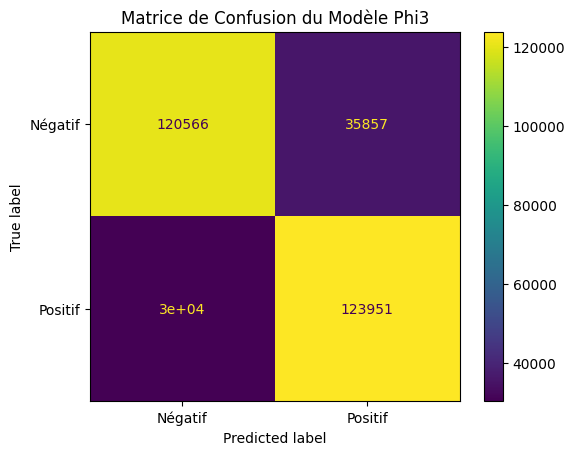

In [27]:
# Calcul de la matrice de confusion entre les pr√©dictions et les labels r√©els
cm = confusion_matrix(label_ids, np.argmax(predictions, axis=1))

# Affichage de la matrice de confusion sous forme de graphique
ConfusionMatrixDisplay(cm, display_labels=['N√©gatif', 'Positif']).plot()
plt.title('Matrice de Confusion du Mod√®le Phi3')
plt.show()

# Fusion de Mod√®le Phi-3 Pr√©-entrain√© et LoRA pour Sauvegarde Standalone

L'objectif est de combiner le mod√®le de base Phi-3 avec les ajustements effectu√©s par LoRA afin de sauvegarder le mod√®le complet en tant que mod√®le standalone, pr√™t pour une utilisation future sans d√©pendre de LoRA s√©par√©ment.

In [2]:
import torch
from transformers import AutoTokenizer,BitsAndBytesConfig,Phi3ForSequenceClassification
from peft import PeftModel, PeftConfig

# Chemin vers le mod√®le complet sauvegard√©
model_path = './models/phi3_model'

# Charger le tokenizer et le mod√®le complet
tokenizer = AutoTokenizer.from_pretrained(model_path)
tokenizer.pad_token = tokenizer.eos_token

# Chemin vers le r√©pertoire de l'adapter sauvegard√©
peft_model_id = './models/phi3_model'

# Charger la configuration de l'adapter pour obtenir le nom du mod√®le de base
config = PeftConfig.from_pretrained(peft_model_id)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,  # Utilisation de la quantification 4-bit pour √©conomiser de la m√©moire
    bnb_4bit_quant_type="nf4",  # Type de quantification utilis√© : Normal-Four (nf4)
    bnb_4bit_use_double_quant=True,  # Activation de la double quantification pour plus d'efficacit√©
    bnb_4bit_compute_dtype=torch.float16  # Type de calcul utilis√© pour la quantification
)

# Limitation de la m√©moire allou√©e pour le mod√®le sur GPU et CPU
max_memory = {
    0: "5GB",  # Limite m√©moire GPU
    "cpu": "25GB"  # Limite m√©moire CPU
}

# Chargement du mod√®le Phi-3 avec quantification 4-bit
model = Phi3ForSequenceClassification.from_pretrained(
    config.base_model_name_or_path,
    quantization_config=bnb_config,  # Configuration de la quantification 4-bit
    device_map="auto",  # Attribution automatique aux dispositifs (GPU/CPU)
    num_labels=2,  # Deux classes (positif, n√©gatif)
    ignore_mismatched_sizes=True,  # Ignore les erreurs de taille de couches incompatibles
    max_memory=max_memory,  # Limites m√©moire pour GPU et CPU
    torch_dtype=torch.float16,  # Utilisation de float16 pour √©conomiser de la m√©moire
    low_cpu_mem_usage=True  # R√©duction de l'utilisation de la m√©moire CPU
)

# Redimensionner les embeddings du mod√®le pour correspondre au vocabulaire du tokenizer
model.resize_token_embeddings(len(tokenizer))

# Charger l'adaptateur (LoRA ou autre) en ignorant √† nouveau les erreurs de taille
model = PeftModel.from_pretrained(
    model, 
    peft_model_id,
    ignore_mismatched_sizes=True  # Ignorer les erreurs de taille des poids de l'adaptateur
)

# Fusionner les poids de LoRA dans le mod√®le de base
model = model.merge_and_unload()  # Fusionne les poids LoRA avec ceux du mod√®le de base

# Sauvegarder le tokenizer
tokenizer.save_pretrained('./models/phi3_model_complete')

# Sauvegarder le mod√®le complet
model.save_pretrained('./models/phi3_model_complete')

Loading checkpoint shards: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2/2 [00:03<00:00,  1.54s/it]
Some weights of Phi3ForSequenceClassification were not initialized from the model checkpoint at microsoft/Phi-3-mini-4k-instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/media/s8n/Jeux video/IA/sentiments/venv/lib/python3.10/site-packages/peft/tuners/lora/bnb.py:336: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


[2024-09-19 16:36:37,655] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/usr/bin/ld¬†: ne peut pas trouver -laio¬†: Aucun fichier ou dossier de ce nom
collect2: error: ld returned 1 exit status
/usr/bin/ld¬†: ne peut pas trouver -lcufile¬†: Aucun fichier ou dossier de ce nom
collect2: error: ld returned 1 exit status


# Analyse de la feature importance globale et locale

## Importations n√©cessaires

/media/s8n/Jeux video/IA/sentiments/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


/media/s8n/Jeux video/IA/sentiments/venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/media/s8n/Jeux video/IA/sentiments/venv/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
PartitionExplainer explainer: 101it [02:51,  1.77s/it]                         

Analyse locale (SHAP text plot) pour les 3 premiers tweets :


Analyse globale (SHAP bar plot) pour la classe positive (ou autre classe) :


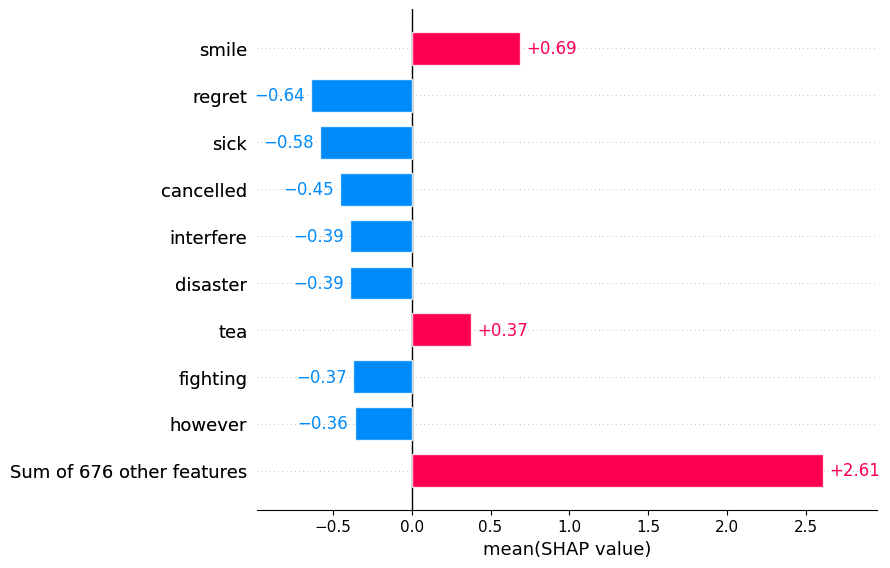

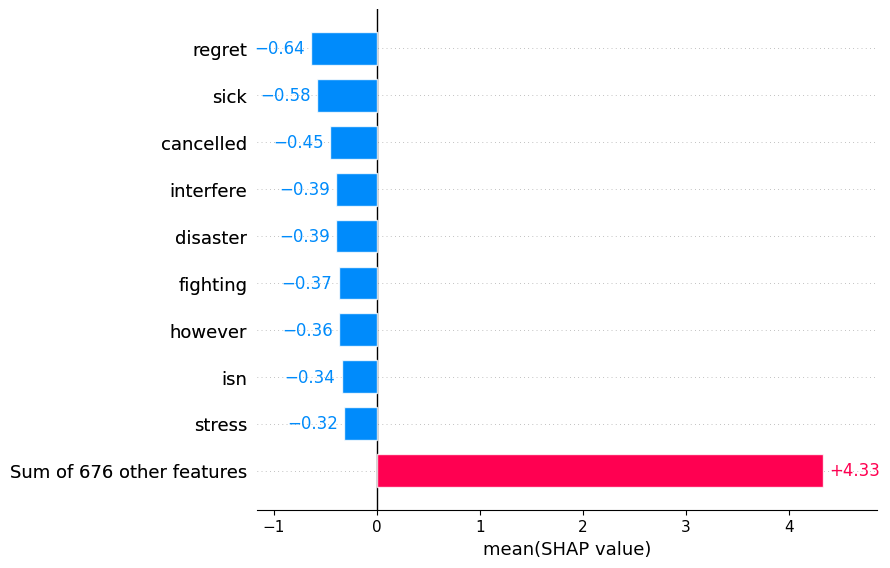

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
import shap

# V√©rifier si CUDA est disponible et s√©lectionner le bon device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Charger le tokenizer BERT avec les tokens sp√©ciaux
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
special_tokens = {'additional_special_tokens': ['[URL]', '[MENTION]', '[HASHTAG]']}
bert_tokenizer.add_special_tokens(special_tokens)

# Charger le mod√®le BERT fine-tun√© et le d√©placer vers le GPU si disponible
bert_model = BertForSequenceClassification.from_pretrained('./models/bert_model')
bert_model.to(device)

# Cr√©er un pipeline pour la classification de sentiments en utilisant CUDA si disponible
bert_classifier = pipeline(
    "sentiment-analysis", 
    model=bert_model, 
    tokenizer=bert_tokenizer, 
    return_all_scores=True,
    device=0 if torch.cuda.is_available() else -1
)

# Charger les donn√©es
data = pd.read_csv('./data/001/sentiment140_cleaned.csv')

# S√©parer les donn√©es en ensembles d'entra√Ænement et de test
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['cleaned_text'], data['target'], test_size=0.2, random_state=42, stratify=data['target']
)

# Limiter l'analyse aux tweets de l'ensemble de test
test_tweets = test_texts[:1000].tolist()

# SHAP - Cr√©er un explainer en utilisant CUDA si disponible
explainer = shap.Explainer(bert_classifier)

# Expliquer les pr√©dictions sur tous les tweets de l'ensemble de test (analyse locale + globale)
shap_values = explainer(test_tweets)

# --- Analyse locale pour les 3 premiers tweets ---
print("Analyse locale (SHAP text plot) pour les 3 premiers tweets :")
shap.plots.text(shap_values[:3])  # Visualiser les explications pour 3 tweets

# --- Analyse globale : Visualiser la moyenne des contributions des tokens ---
print("Analyse globale (SHAP bar plot) pour la classe positive (ou autre classe) :")
# Remplacer "positive" par l'indice ou la classe souhait√©e, par exemple shap_values[:, :, 1] pour la classe 1
shap.plots.bar(shap_values[:, :, 1].mean(0))

# Visualiser les tokens ayant le plus d'impact (ordonn√©)
shap.plots.bar(shap_values[:, :, 1].mean(0), order=shap.Explanation.argsort)


/media/s8n/Jeux video/IA/sentiments/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


Using device: cuda


/media/s8n/Jeux video/IA/sentiments/venv/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
You are not running the flash-attention implementation, expect numerical differences.
  0%|          | 0/380 [00:00<?, ?it/s]You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
PartitionExplainer explainer: 11it [06:55, 41.55s/it]                        

Analyse locale (SHAP text plot) pour les 3 premiers tweets :


Analyse globale (SHAP bar plot) pour la classe positive :


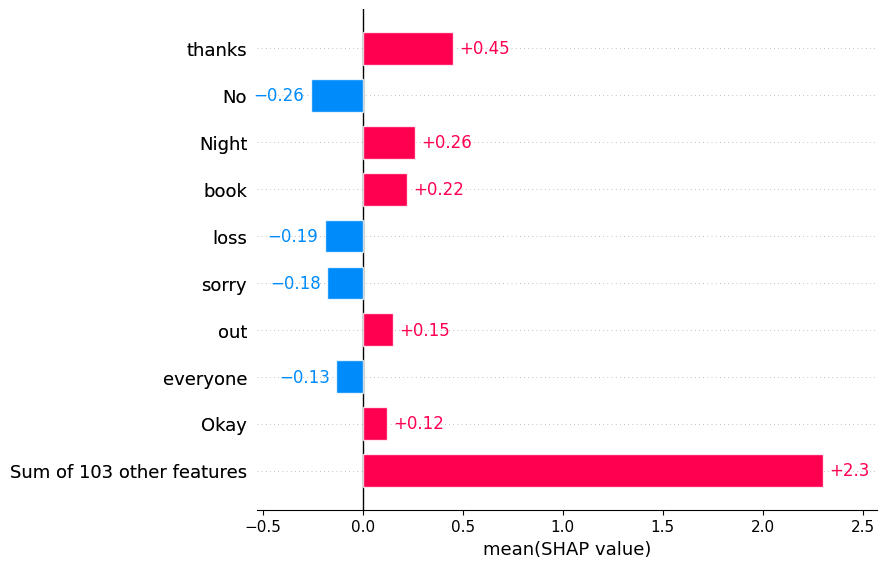

Tokens ayant le plus d'impact (ordonn√©s) :


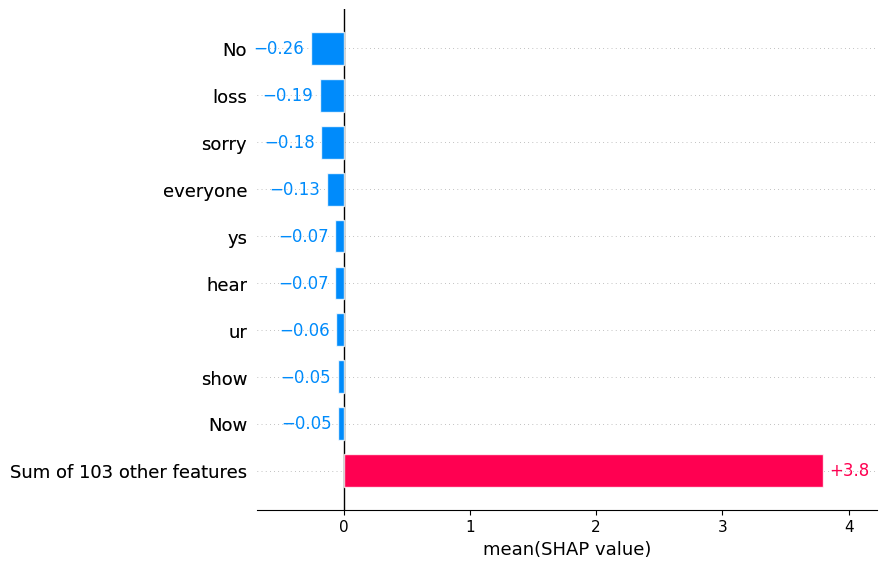

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from transformers import AutoTokenizer, pipeline,BitsAndBytesConfig,Phi3ForSequenceClassification
import shap

# V√©rifier si CUDA est disponible et s√©lectionner le bon device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Chemin vers le mod√®le complet sauvegard√©
model_path = './models/phi3_model_complete'

# Charger le tokenizer et le mod√®le complet
tokenizer = AutoTokenizer.from_pretrained(model_path)
tokenizer.pad_token = tokenizer.eos_token

# Chargement du mod√®le Phi-3 avec quantification 4-bit
model = Phi3ForSequenceClassification.from_pretrained(model_path)

# Cr√©er un pipeline pour la classification de sentiments en utilisant CUDA si disponible
classifier = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True,
)

# Charger les donn√©es
data = pd.read_csv('./data/001/sentiment140_cleaned.csv')

# S√©parer les donn√©es en ensembles d'entra√Ænement et de test
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['cleaned_text'], data['target'], test_size=0.2, random_state=42, stratify=data['target']
)

# Limiter l'analyse aux tweets de l'ensemble de test
test_tweets = test_texts[:10].tolist()

# SHAP - Cr√©er un explainer en utilisant CUDA si disponible
explainer = shap.Explainer(classifier)

# Expliquer les pr√©dictions sur tous les tweets de l'ensemble de test (analyse locale + globale)
shap_values = explainer(test_tweets)

# --- Analyse locale pour les 3 premiers tweets ---
print("Analyse locale (SHAP text plot) pour les 3 premiers tweets :")
shap.plots.text(shap_values[:3])  # Visualiser les explications pour 3 tweets

# --- Analyse globale : Visualiser la moyenne des contributions des tokens ---
print("Analyse globale (SHAP bar plot) pour la classe positive :")
shap.plots.bar(shap_values[:, :, 1].mean(0))

# Visualiser les tokens ayant le plus d'impact (ordonn√©)
print("Tokens ayant le plus d'impact (ordonn√©s) :")
shap.plots.bar(shap_values[:, :, 1].mean(0), order=shap.Explanation.argsort)

# Lib√©rer les ressources li√©es au mod√®le et √† CUDA
del model
del classifier
del explainer
del shap_values

# Vider le cache CUDA pour lib√©rer la VRAM
torch.cuda.empty_cache()